# Panama Canal drought study

Data sources:
- Gridded data from CHIRPS and MSWEP
- Monthly precipitation data from [Panama Canal Authority stations](https://biogeodb.stri.si.edu/physical_monitoring/research/panamacanalauthority#download), [Barro Colorado](https://biogeodb.stri.si.edu/physical_monitoring/research/barrocolorado) and other stations; 2023 data provided by ACP directly
- lake level data from [Panama Canal Authority](https://evtms-rpts.pancanal.com/eng/h2o/index.html) (https://pancanal.com/en/)

**Notes from kick-off meeting**
- dry season (Jan-Apr) is irrelevant for precip - wet season (May-Dec) largely irrelevant for PET
- PET is expected to be insignificant compared to water usage - typically about 1-3mm/day in wet season, 5-8mm/day in dry season
- temperatures have increased by about 1C in this region (2C for nighttime temperatures) - no change in windspeed or direction
- use ACP core stations (50 or so) within the watershed - also include coastal stations from STRI
- El Nino has strong correlation with dry years - La Nina is less strongly linked to wet years (although variability is higher in wet years)
- over long time series there's clear evidence of a decadal oscillation - which seems to be linked to the AMO
- December precip was very low this year: maybe that would also be worth looking at? (Also May, which has more of an effect on lake levels dropping - December more important for replenishment)
&nbsp;
- an interesting follow-up question: what happens in the second half of the second year? This is when replenishment should occur

In [2]:
import sys; sys.path.append('..'); from wwa import *
from scipy.stats import spearmanr, pearsonr
import calendar

cproj = cartopy.crs.PlateCarree()
# xn, xx, yn, yx = [-80.25,-79.25,8.7,9.7] # original bounds
xn, xx, yn, yx = [-80.5,-79.25,8.7,9.7] # revised after comparison with station data

bci_px = {"lon" : -79.838234, "lat" : 9.163114}

days = pd.date_range(start = "2020-01-01", end = "2020-12-31")
gridlines = [i+1 for i in range(366) if (days[i].day) == 1]
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[:1] for i in range(366) if (days[i].day) == 1]

In [3]:
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", message = ".+naturalearth.+")

# Background information

## Physical geography

In [158]:
elev = xr.open_dataset("data/gebco_2023_n11.0_s6.0_w-85.0_e-75.0.nc").elevation
sf = gpd.read_file("sf_hybas06").clip((xn, xx, yn, yx))

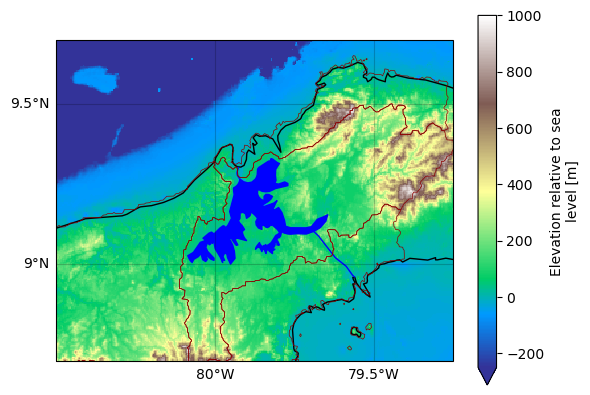

In [159]:
elev.sel(lon = slice(xn,xx), lat = slice(yn,yx)).plot(cmap = "terrain", vmax = 1000, vmin = -250, subplot_kws = {"projection" : cproj, "extent" : (xn, xx, yn, yx)})
ax = plt.gca()
ax.coastlines()
ax.add_feature(cartopy.feature.LAKES, color = "blue")
ax.add_feature(cartopy.feature.RIVERS, color = "blue")
ax.gridlines(color = "k", alpha = 0.2, draw_labels = ["left", "bottom"], xlocs = np.arange(np.floor(xn),xx+0.5,0.5), ylocs = np.arange(np.floor(yn),yx+0.5,0.5))
sf.boundary.plot(ax = ax, color = "darkred", lw = 0.5)

plt.savefig("fig/elevation.png")

## Station locations

In [ ]:
acp = pd.read_csv("data/stations_acp.csv", index_col = 0)

In [142]:
stri = pd.read_csv("data/stations_stri.csv", index_col = 0)

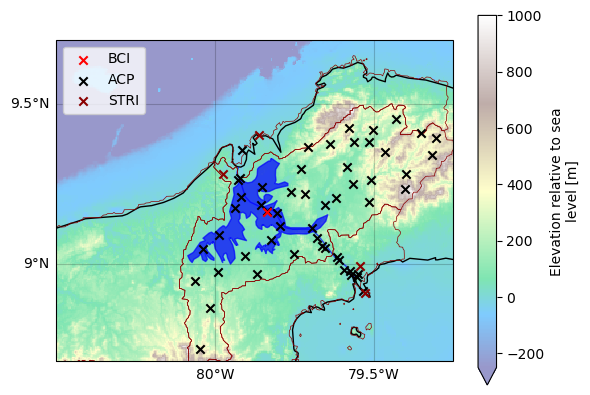

In [157]:
# fig, ax = plt.subplots(ncols = 1, subplot_kw = {"projection" : cproj, "extent" : (xn, xx, yn, yx)})
elev.sel(lon = slice(xn,xx), lat = slice(yn,yx)).plot(cmap = "terrain", vmax = 1000, vmin = -250, alpha = 0.5, subplot_kws = {"projection" : cproj, "extent" : (xn, xx, yn, yx)})
ax = plt.gca()
ax.coastlines()
ax.add_feature(cartopy.feature.LAKES, color = "blue", alpha = 0.7)
ax.add_feature(cartopy.feature.RIVERS, color = "blue", alpha = 0.7)
ax.gridlines(color = "k", alpha = 0.2, draw_labels = ["left", "bottom"], xlocs = np.arange(np.floor(xn),xx+0.5,0.5), ylocs = np.arange(np.floor(yn),yx+0.5,0.5))
sf.boundary.plot(ax = ax, color = "darkred", lw = 0.5)

ax.scatter(bci_px["lon"], bci_px["lat"], marker = "x", c = "red", zorder = 99, label = "BCI")
ax.scatter(acp.lon, acp.lat, marker = "x", c = "k", zorder = 98, label = "ACP")
ax.scatter(stri.lon, stri.lat, marker = "x", c = "darkred", zorder = 98, label = "STRI")

ax.legend(loc = "upper left")
plt.savefig("fig/station-locations.png")

---
## Lake level data
https://evtms-rpts.pancanal.com/eng/h2o/index.html (https://pancanal.com/en/)

- the three driest years observed were 1997, 2015 and 2023 (in order of accumulated precip deficit by September)  
- in all three of these years, the lake levels were roughly the same at the start of the year (about 87.5ft) -
the 2023 level has dropped much more quickly than in either 1997 or 2015.  
&nbsp;
- Jun-Sep 2023 is the longest that levels have remained this low.
&nbsp;
- previously, the lowest levels have occurred in April-June of the years following the lowest precipitation, then recovered quickly.  
This suggests that next year, levels might be even lower.


In [17]:
df = pd.read_csv("data/Download_Gatun_Lake_Water_Level_History.csv", parse_dates = ["DATE_LOG"], index_col = 0)
df = df.rename(columns = {"GATUN_LAKE_LEVEL(FEET)" : "level"})

In [18]:
df.loc[df.level == 0, "level"] = np.nan # remove zeros

In [19]:
df[np.abs(df - df.rolling(15).mean()) > 1] = np.nan # remove any readings that are more than 1ft from the smoothed line (seems implausible)

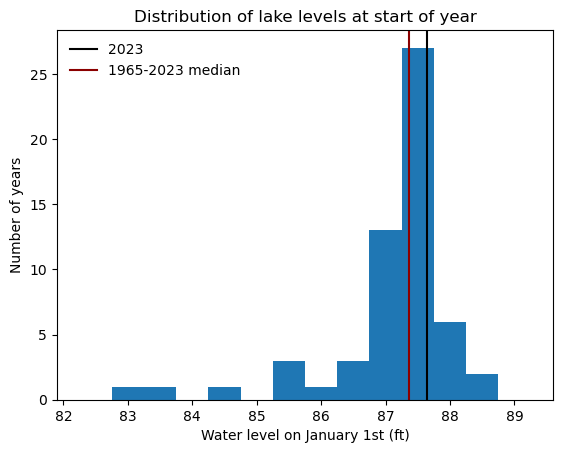

In [20]:
# lake level at start of each year - 2023 not particularly unusual - in fact, above the median level
df.loc[df.index.day_of_year == 1].hist(grid = False, bins = np.arange(82.25, 89.75,0.5))

# df.loc[df.index.day_of_year == 1].loc[slice("1990","2020")].hist(ax = plt.gca(), grid = False, bins = np.arange(82.25, 89.75,0.5), alpha = 0.3, color = "darkblue")

plt.gca().axvline(df.loc["2023-01-01", "level"], color = "k", label = "2023")
plt.gca().axvline(df.loc[df.index.day_of_year == 1, "level"].median(), color = "darkred", label = "1965-2023 median")

plt.legend(edgecolor = "w")

plt.xlabel("Water level on January 1st (ft)")
plt.ylabel("Number of years")
plt.title("Distribution of lake levels at start of year")
plt.savefig("fig/starting-level-histogram.png")

In [21]:
df_proj = pd.read_csv("data/Gatun_Water_Level_Projection.csv", skiprows = 3, header = None, names = ["proj_date", "level", "surcharge", "maxd_1", "maxd_2"],
           index_col = 0, parse_dates = [0]).sort_values("proj_date")[["level"]]

In [22]:
df_clim = df.loc[slice("1990", "2020")].groupby(df.loc[slice("1990", "2020")].index.day_of_year).mean()

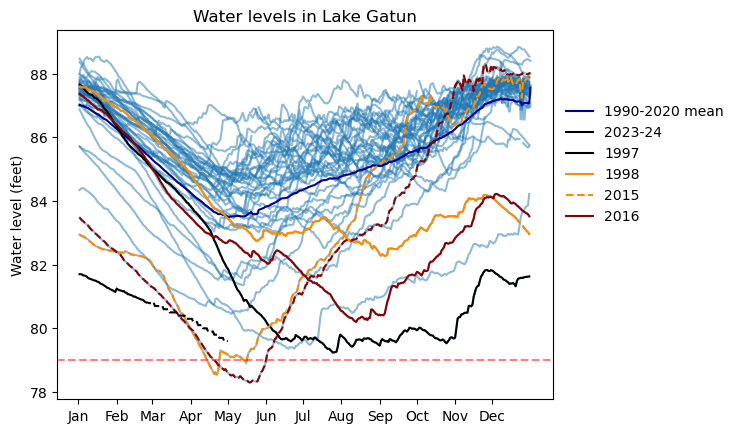

In [23]:
df_clim.plot(color = "darkblue", legend = False)
ax = plt.gca()
   
ts_y = df.loc[str(2023)]
ts_y.index = ts_y.index.day_of_year
ts_y.plot(ax = ax, color = "k", legend = False)

ts_y = df.loc[str(2024)]
ts_y.index = ts_y.index.day_of_year
ts_y.plot(ax = ax, color = "k", legend = False)

ts_y = df.loc[str(1997)]
ts_y.index = ts_y.index.day_of_year
ts_y.plot(ax = ax, color = "darkorange", legend = False)

ts_y = df.loc[str(1998)]
ts_y.index = ts_y.index.day_of_year
ts_y.plot(ax = ax, color = "darkorange", legend = False, ls = "--")

ts_y = df.loc[str(2015)]
ts_y.index = ts_y.index.day_of_year
ts_y.plot(ax = ax, color = "darkred", legend = False)

ts_y = df.loc[str(2016)]
ts_y.index = ts_y.index.day_of_year
ts_y.plot(ax = ax, color = "darkred", legend = False, ls = "--")

for y in range(1981, 2024):
    ts_y = df.loc[str(y)]
    ts_y.index = ts_y.index.day_of_year
    ts_y.plot(ax = ax, color = "tab:blue", alpha = 0.5, legend = False, label = "_", zorder = -99)
    

for y in range(2024, 2025):
    ts_y = df_proj.loc[str(y)]
    ts_y.index = ts_y.index.day_of_year
    ts_y.plot(ax = ax, color = "k", ls = "--", legend = False)

sc_xlabels(dates = df.loc["2020"].to_xarray().DATE_LOG)
plt.gcf().legend(["1990-2020 mean", "2023-24", "1997","1998","2015","2016"], bbox_to_anchor = (0.9,0.6), loc = "center left", edgecolor = "w")
ax.set_xlabel("")
ax.set_ylabel("Water level (feet)")
ax.set_title("Water levels in Lake Gatun")

ax.axhline(79, color = "red", alpha = 0.5, ls = "--")

plt.savefig("fig/water-levels.png")

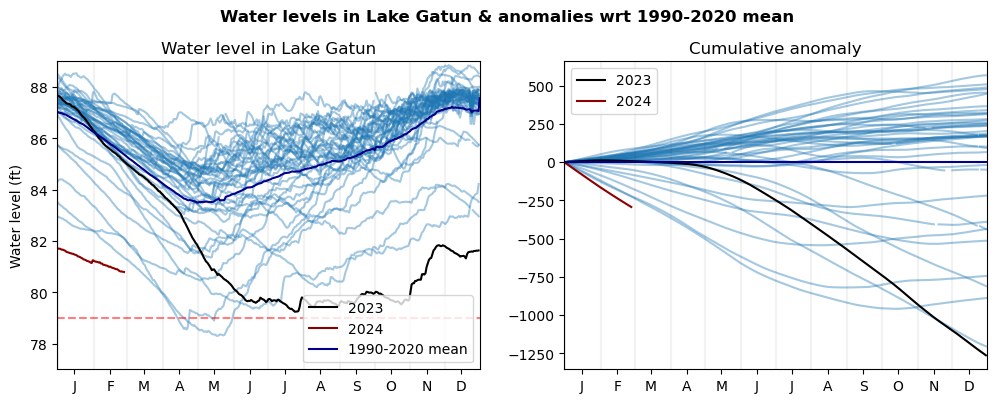

In [24]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[0]

for y in range(1981, 2023):
    ts_y = df.loc[str(y)]
    ts_y.index = ts_y.index.day_of_year
    ax.plot(ts_y.index, ts_y, color = "tab:blue", alpha = 0.4)

ts_y = df.loc[str(2023)]
ts_y.index = ts_y.index.day_of_year
ax.plot(ts_y.index, ts_y, color = "k", label = "2023")    

ts_y = df.loc[str(2024)]
ts_y.index = ts_y.index.day_of_year
ax.plot(ts_y.index, ts_y, color = "darkred", label = "2024")   

ax.plot(df_clim.index, df_clim, color = "darkblue", label = "1990-2020 mean")    
ax.set_ylim(77,89)
ax.axhline(79, color = "red", alpha = 0.5, ls = "--")
ax.legend()
ax.set_ylabel("Water level (ft)")
ax.set_title("Water level in Lake Gatun")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# cumulative anomaly
def ts_fun(ts): 
    zz = pd.merge(ts, df_clim, left_on = ts.index.day_of_year, right_index  = True)
    zz["diff"] = zz.level_x - zz.level_y
    return zz[["diff"]].cumsum()

ax = axs[1]

for y in range(1981, 2023):
    ts_y = ts_fun(df.loc[str(y)])
    ax.plot(ts_y.index.day_of_year, ts_y, color = "tab:blue", alpha = 0.4)

ts_y = ts_fun(df.loc[str(2023)])
ax.plot(ts_y.index.day_of_year, ts_y, color = "k", alpha = 1, label = "2023")

ts_y = ts_fun(df.loc[str(2024)])
ax.plot(ts_y.index.day_of_year, ts_y, color = "darkred", alpha = 1, label = "2024")

plt.axhline(0, color = "darkblue")
ax.set_title("Cumulative anomaly")
ax.legend()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for ax in axs:
    ax.set_xticks(labelticks); ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in gridlines]
    ax.set_xlabel("")
    ax.set_xlim(0,366)
    
plt.suptitle("Water levels in Lake Gatun & anomalies wrt 1990-2020 mean", fontweight = "bold", y = 1.01)

plt.savefig("fig/water-levels-with-anomaly.png")

---
# Exploratory analysis

## Seasonal cycle of precipitation

In [62]:
# load daily time series over the region
chirps, mswep = [xr.open_dataset("data/"+ds+"_panama_ts.nc").pr.sel(time = slice(None, "2023")).resample(time = "MS").sum() for ds in ["chirps", "mswep"]]

acp = pd.read_csv("data/pr_stations_acp_monthly.csv", index_col = 0, parse_dates = [0])
acp = acp.mean(axis = 1).dropna(axis = 0, how = "all").to_xarray().rename("pr", index = "time")

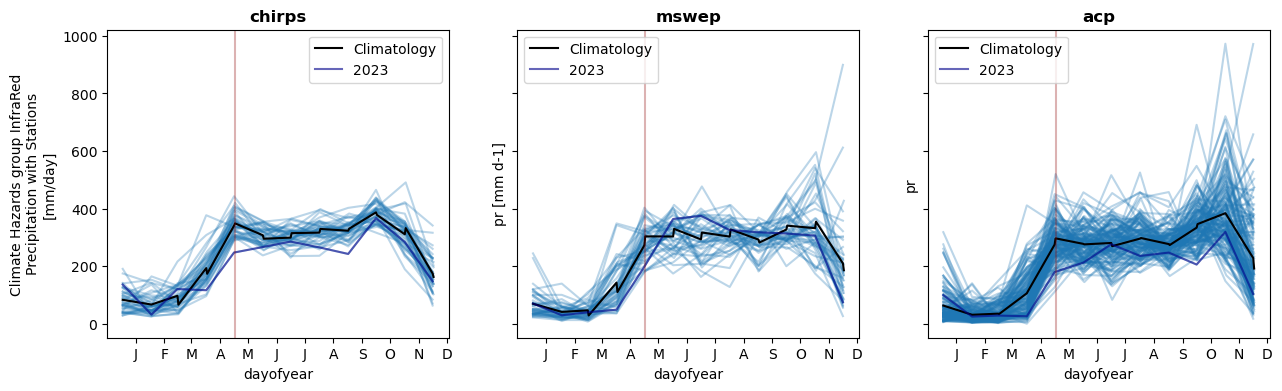

In [63]:
fig, axs = plt.subplots(ncols = 3, nrows = 1, figsize = (15,4), dpi = 100, sharex = True, sharey = True)

for i in range(3):
    ax = axs[i]
    ds = ["chirps", "mswep", "acp"][i]
    ts = eval(ds)
    
    for y in np.unique(ts.time.dt.year.values):
        ts_y = ts.sel(time = str(y))
        ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.3)

    ts.groupby("time.dayofyear").mean().plot(ax = ax, color = "k", label = "Climatology")
    ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "darkblue", alpha = 0.6, label = "2023")

    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)

    ax.set_title(ds, fontweight = "bold")
    ax.legend()

    ax.axvline(ts.sel(time = "2020-05-01").time.dt.dayofyear, color = "darkred", alpha = 0.3)

## Maps of 2023 precipitation anomaly

In [92]:
# compute climatology & anomalies
chirps_clim, mswep_clim = [da.sel(time = slice("1990", "2020")).mean("time") for da in [chirps, mswep]]
chirps_anom = chirps - chirps_clim
mswep_anom = mswep - mswep_clim

In [ ]:
# get annual mean (whole years only)
stn_pr = pd.read_csv("data/pr_monthly_acp.csv", index_col = 0, parse_dates = [0])
stn_ann = stn_pr.resample("AS-JAN").sum()
stn_ann = stn_ann.where(stn_pr.resample("AS-JAN").count() == 12)

# get climatology (require min 20 years) and then anomaly
stn_clim = stn_ann.loc[slice("1990", "2020")].mean().where(stn_ann.loc[slice("1990", "2020")].count() >= 20)
stn_anom = stn_ann.loc["2023"] - stn_clim
stn_anom.index = ["anom_2023"]

# add 2023 anomaly to station lats & lons to get single dataframe for plotting
stn_data = pd.merge(pd.read_csv("data/acp_stations.csv", index_col = 0), stn_anom.transpose(), left_index = True, right_index = True)
stn_data = stn_data.dropna(axis = 0, how = "any")

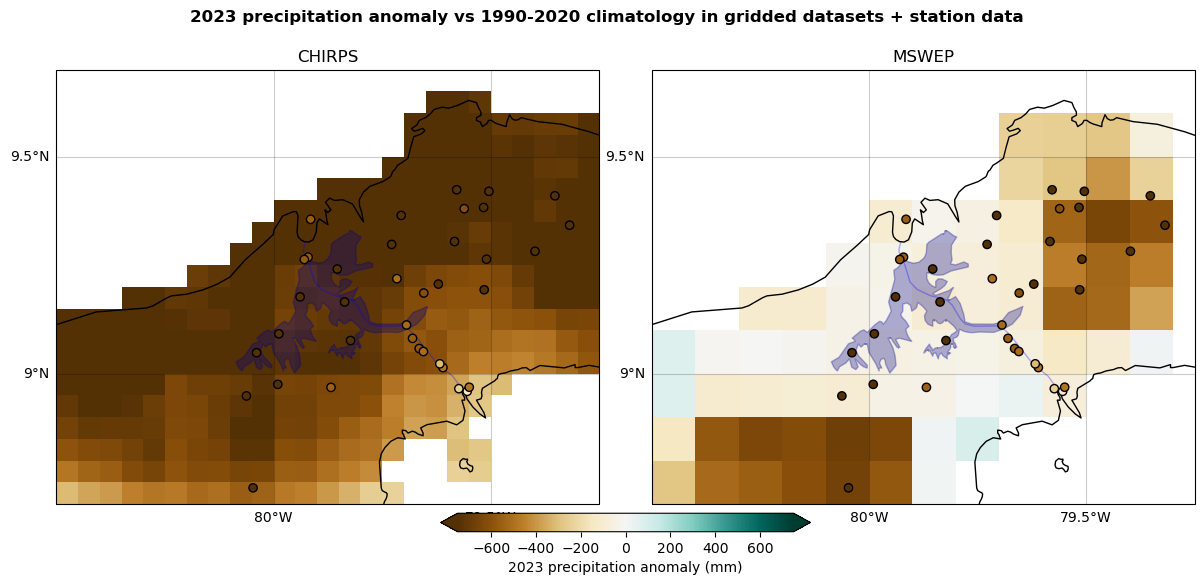

In [101]:
fig, axs = plt.subplots(ncols = 2, figsize = (15,6), dpi = 100, subplot_kw = {"projection" : cproj}, sharex = True, sharey = True)
plt.subplots_adjust(wspace = 0.05)
plot_kwargs = {"vmin" : -750, "vmax" : 750, "cmap" : "BrBG"}

for i in range(2):
    ds = ["chirps", "mswep"][i]
    ax = axs[i]

    anom = eval(ds+"_anom").sel(lon = slice(xn,xx), lat = slice(yn,yx))
    cbar = anom.sel(time = "2023").plot(ax = ax, **plot_kwargs, add_colorbar = False)
    ax.set_title(ds.upper())

    ax.scatter(stn_data.lon, stn_data.lat, c = stn_data.anom_2023, **plot_kwargs, zorder = 99, edgecolor = "k")

    ax.coastlines()
    ax.add_feature(cartopy.feature.LAKES, color = "darkblue", alpha = 0.3)
    ax.add_feature(cartopy.feature.RIVERS, color = "blue", alpha = 0.3)
    ax.gridlines(color = "k", alpha = 0.2, draw_labels = ["left", "bottom"], xlocs = np.arange(np.floor(xn),xx+0.5,0.5), ylocs = np.arange(np.floor(yn),yx+0.5,0.5))

plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.04, pad = 0.02, label = "2023 precipitation anomaly (mm)", extend = "both")

plt.suptitle("2023 precipitation anomaly vs 1990-2020 climatology in gridded datasets + station data", fontweight = "bold")
plt.savefig("fig/2023-anom-map.png")

## Barro Colorado

### 2023 precipitation

In [ ]:
chirps_bci = xr.open_dataset("data/chirps05_panama.nc").precip.sel(longitude = bci_px["bci"]["lon"], latitude = bci_px["bci"]["lat"], method = "nearest").squeeze(drop = True).resample(time = "MS").sum()
mswep_bci = xr.open_dataset("data/mswep_panama.nc").pr.sel(lon = bci_px["bci"]["lon"], lat = bci_px["bci"]["lat"], method = "nearest").squeeze(drop = True).resample(time = "MS").sum()
bci = pd.read_csv("data/bci_monthly.csv", index_col = 0, parse_dates = [0])[["pr"]].rename(columns = {"pr" : "station"})

df = merge_byindex([bci, chirps_bci.rename("chirps").to_dataframe()[["chirps"]], mswep_bci.rename("mswep").to_dataframe()[["mswep"]]])
df = df.dropna(axis = 0, how = "all")

df_clim = df.loc[slice("1990", "2020")].mean()

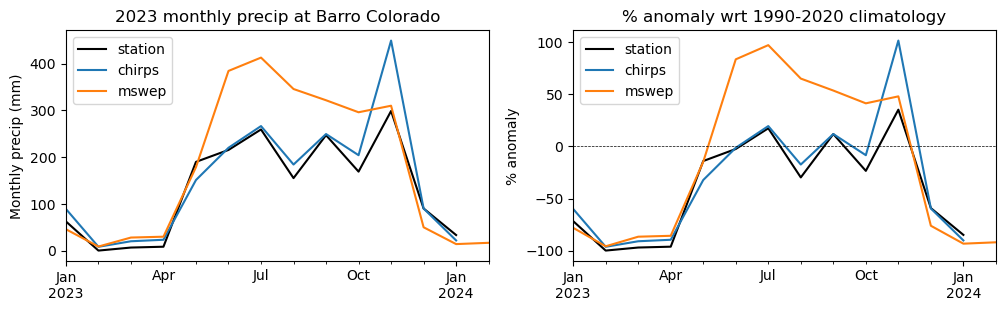

In [245]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,3), dpi = 100)

ds_cols = ["k", "tab:blue", "tab:orange"]

ax = axs[0]
df.loc[slice("2023", None)].plot(ax = ax, color = ds_cols)
ax.set_ylabel("Monthly precip (mm)")
ax.set_title("2023 monthly precip at Barro Colorado")

ax = axs[1]
((df.loc[slice("2023", None)] - df.loc[slice("1990", "2020")].mean()) / df.loc[slice("1990", "2020")].mean() * 100).plot(ax = ax, color = ds_cols)
ax.axhline(0, color = "k", ls = "--", lw = 0.5)
ax.set_ylabel("% anomaly")
ax.set_title("% anomaly wrt 1990-2020 climatology")

plt.savefig("fig/2023-anom-ts_bci.png")

### Trends in precipitation

In [246]:
chirps_bci = xr.open_dataset("data/chirps05_panama.nc").precip.sel(longitude = bci_px["bci"]["lon"], latitude = bci_px["bci"]["lat"], method = "nearest").squeeze(drop = True).resample(time = "AS-JAN").sum()
mswep_bci = xr.open_dataset("data/mswep_panama.nc").pr.sel(lon = bci_px["bci"]["lon"], lat = bci_px["bci"]["lat"], method = "nearest").squeeze(drop = True).resample(time = "AS-JAN").sum()
bci = pd.read_csv("data/bci_monthly.csv", index_col = 0, parse_dates = [0])[["pr"]].rename(columns = {"pr" : "station"}).resample("AS-JAN").sum()

df = merge_byindex([bci, chirps_bci.rename("chirps").to_dataframe()[["chirps"]], mswep_bci.rename("mswep").to_dataframe()[["mswep"]]])
df = df.dropna(axis = 0, how = "all")

df_clim = df.loc[slice("1990", "2020")].mean()

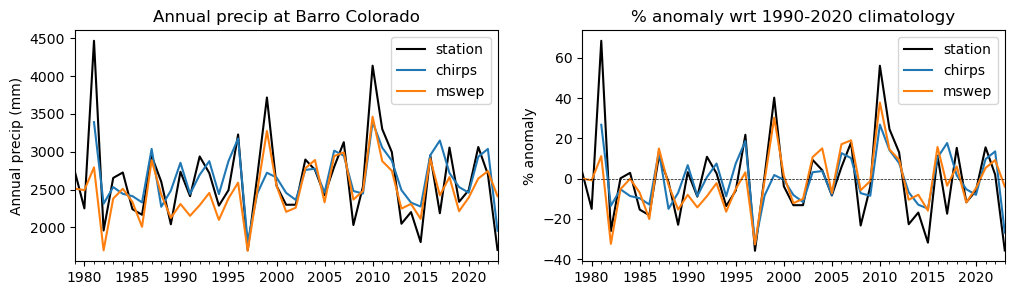

In [247]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,3), dpi = 100)

ax = axs[0]
df.loc[slice("1979","2023")].plot(ax = ax, color = ds_cols)
ax.set_ylabel("Annual precip (mm)")
ax.set_title("Annual precip at Barro Colorado")

ax = axs[1]
((df.loc[slice("1979","2023")] - df.loc[slice("1990", "2020")].mean()) / df.loc[slice("1990", "2020")].mean() * 100).plot(ax = ax, color = ds_cols)
ax.axhline(0, color = "k", ls = "--", lw = 0.5)
ax.set_ylabel("% anomaly")
ax.set_title("% anomaly wrt 1990-2020 climatology")

plt.savefig("fig/precip-ts-bci.png")

### Cumulative precipitation deficit

In [ ]:
chirps_bci = xr.open_dataset("data/chirps05_panama.nc").precip.sel(longitude = bci_px["lon"], latitude = bci_px["lat"], method = "nearest").squeeze(drop = True).reset_coords(drop = True).load()
mswep_bci = xr.open_dataset("data/mswep_panama.nc").pr.sel(lon = bci_px["lon"], lat = bci_px["lat"], method = "nearest").squeeze(drop = True).reset_coords(drop = True).load()
bci = pd.read_csv("data/bci_monthly.csv", index_col = 0, parse_dates = [0])[["pr"]].rename(columns = {"pr" : "station"})

In [ ]:
bci_sc = bci.loc[slice("1990","2020")].groupby(bci.loc[slice("1990","2020")].index.month).mean()
bci_anomc = (bci.loc["2023"] - bci_sc.values).cumsum()

In [379]:
bci_anomc.resample("M").mean()

station
2023-01-31  -10.030181
2023-02-28  -37.574463
2023-03-31  -78.584845
2023-04-30 -172.432113
2023-05-31 -284.167670
2023-06-30 -352.164267
2023-07-31 -381.572820
2023-08-31 -518.256917
2023-09-30 -525.280239
2023-10-31 -652.772176
2023-11-30 -772.288086
2023-12-31 -946.864358

In [341]:
chirps_sc = chirps_bci.sel(time = slice("1990", "2020")).groupby("time.dayofyear").mean()
mswep_sc = chirps_bci.sel(time = slice("1990", "2020")).groupby("time.dayofyear").mean()

In [ ]:
chirps_anomc = (chirps_bci.sel(time = "2023").groupby("time.dayofyear") - chirps_sc).cumsum()
mswep_anomc = (mswep_bci.sel(time = "2023").groupby("time.dayofyear") - mswep_sc).cumsum()

Text(0.5, 1.0, 'Cumulative precipitation deficit 2023')

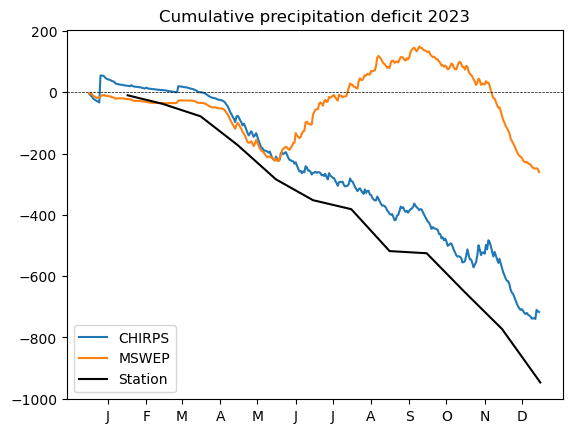

In [387]:
plt.plot(chirps_anomc, label = "CHIRPS")
plt.plot(mswep_anomc, label = "MSWEP")
plt.plot(bci_anomc.resample("M").mean().index.day_of_year, bci_anomc.values, color = "k", label = "Station")

ax = plt.gca()
ax.set_xticks(labelticks); ax.set_xticklabels(labels)

ax.axhline(0, color = "k", ls = "--", lw = 0.5)
ax.legend()

ax.set_title("Cumulative precipitation deficit 2023")

#### BCI: APC vs STRI
Confirmed that readings are mostly very similar in both sources - use APC for ease of processing

<AxesSubplot: >

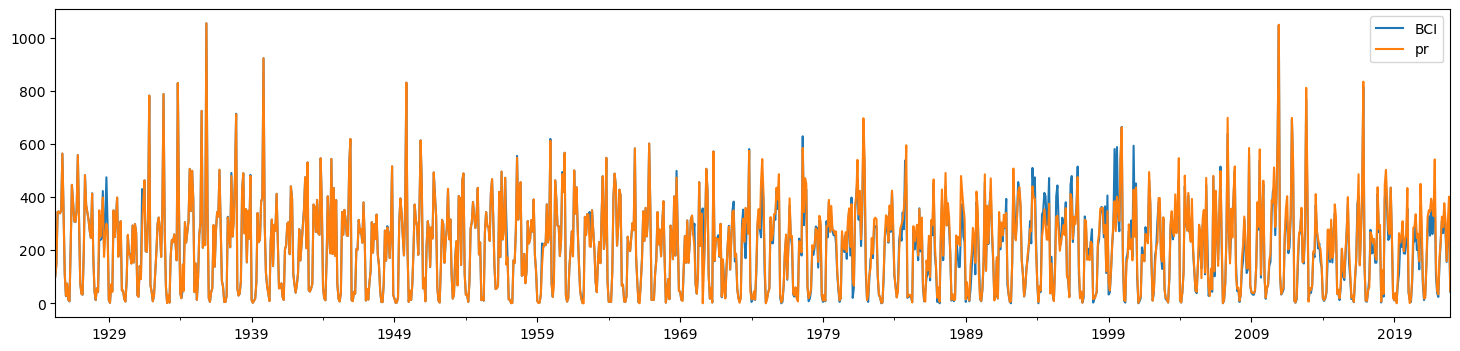

In [112]:
acp_pr = pd.read_csv("data/acp_monthly-pr.csv", index_col = 0, parse_dates = [0])
acp_stations = pd.read_csv("data/acp_stations.csv", index_col = 0)
bci = pd.read_csv("data/bci_monthly.csv", index_col = 0, parse_dates = [0])[["pr"]]

zz = pd.merge(acp_pr[["BCI"]].dropna(axis = 0, how = "any"), bci, left_index = True, right_index = True)
zz.plot(figsize = (18,4))

## Time series over whole region

### 2023 precipitation

In [ ]:
acp = pd.read_csv("data/acp_monthly-pr.csv", index_col = 0, parse_dates = [0])
acp = acp.dropna(0, "all").loc[slice("1979", "2023")].dropna(1, "all").resample("AS-JAN").sum()
acp = acp.where(acp > 0)

acp_mean = acp.mean(1).to_frame()
acp_mean = acp_mean.rename(columns = {0: "ACP mean"})

chirps_bci = xr.open_dataset("data/chirps05_panama.nc").precip.sel(longitude = slice(xn,xx), latitude = slice(yn,yx)).mean(["longitude", "latitude"]).resample(time = "AS-JAN").sum()
mswep_bci = xr.open_dataset("data/mswep_panama.nc").pr.sel(lon = slice(xn,xx), lat = slice(yn,yx)).mean(["lon", "lat"]).resample(time = "AS-JAN").sum()

df = merge_byindex([acp_mean, chirps_bci.rename("chirps").to_dataframe()[["chirps"]], mswep_bci.rename("mswep").to_dataframe()[["mswep"]]])
df = df.dropna(axis = 0, how = "all")

df.index = df.index.year
df.to_csv("ts/pr_annual_box.csv")

In [ ]:
chirps_bci = xr.open_dataset("data/chirps05_panama.nc").precip.sel(longitude = slice(xn,xx), latitude = slice(yn,yx)).mean(["longitude", "latitude"])
mswep_bci = xr.open_dataset("data/mswep_panama.nc").pr.sel(lon = slice(xn,xx), lat = slice(yn,yx)).mean(["lon", "lat"])

df = merge_byindex([chirps_bci.rename("chirps").to_dataframe()[["chirps"]], mswep_bci.rename("mswep").to_dataframe()[["mswep"]]])
df = df.dropna(axis = 0, how = "all")

df_clim = df.loc[slice("1990", "2020")].mean()

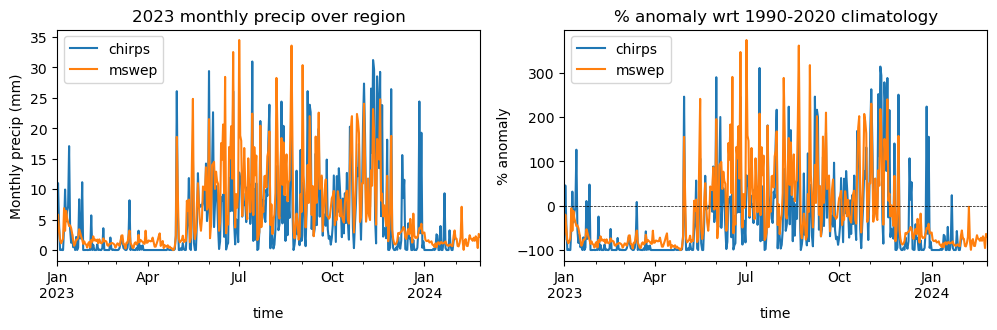

In [249]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,3), dpi = 100)
ds_cols = ["tab:blue", "tab:orange"]
ax = axs[0]
df.loc[slice("2023", None)].plot(ax = ax, color = ds_cols)
ax.set_ylabel("Monthly precip (mm)")
ax.set_title("2023 monthly precip over region")

ax = axs[1]
((df.loc[slice("2023", None)] - df.loc[slice("1990", "2020")].mean()) / df.loc[slice("1990", "2020")].mean() * 100).plot(ax = ax, color = ds_cols)
ax.axhline(0, color = "k", ls = "--", lw = 0.5)
ax.set_ylabel("% anomaly")
ax.set_title("% anomaly wrt 1990-2020 climatology")

plt.savefig("fig/2023-anom-ts_box.png")

### Trends in precipitation

In [ ]:
acp = pd.read_csv("data/acp_monthly-pr.csv", index_col = 0, parse_dates = [0])
acp = acp.dropna(0, "all").loc[slice("1979", "2023")].dropna(1, "all").resample("AS-JAN").sum()
acp = acp.where(acp > 0)

In [302]:
acp_mean = acp.mean(1).to_frame()
acp_mean = acp_mean.rename(columns = {0: "ACP mean"})

In [303]:
chirps_bci = xr.open_dataset("data/chirps05_panama.nc").precip.sel(longitude = slice(xn,xx), latitude = slice(yn,yx)).mean(["longitude", "latitude"]).resample(time = "AS-JAN").sum()
mswep_bci = xr.open_dataset("data/mswep_panama.nc").pr.sel(lon = slice(xn,xx), lat = slice(yn,yx)).mean(["lon", "lat"]).resample(time = "AS-JAN").sum()

df = merge_byindex([acp_mean, chirps_bci.rename("chirps").to_dataframe()[["chirps"]], mswep_bci.rename("mswep").to_dataframe()[["mswep"]]])
df = df.dropna(axis = 0, how = "all")

df_clim = df.loc[slice("1990", "2020")].mean()

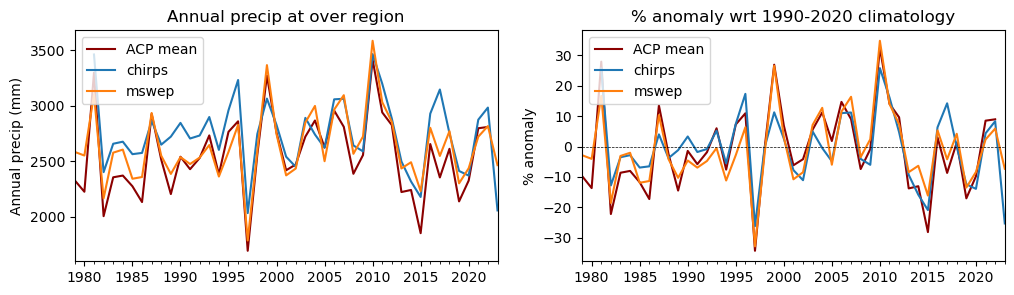

In [306]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,3), dpi = 100)

ds_cols = ["darkred", "tab:blue", "tab:orange"]
ax = axs[0]
df.loc[slice("1979","2023")].plot(ax = ax, color = ds_cols)
ax.set_ylabel("Annual precip (mm)")
ax.set_title("Annual precip at over region")

ax = axs[1]
((df.loc[slice("1979","2023")] - df.loc[slice("1990", "2020")].mean()) / df.loc[slice("1990", "2020")].mean() * 100).plot(ax = ax, color = ds_cols)
ax.axhline(0, color = "k", ls = "--", lw = 0.5)
ax.set_ylabel("% anomaly")
ax.set_title("% anomaly wrt 1990-2020 climatology")

plt.savefig("fig/precip-ts_box.png")

### Cumulative precipitation deficit

In [ ]:
acp = pd.read_csv("data/acp_monthly-pr.csv", index_col = 0, parse_dates = [0])
acp = acp.dropna(0, "all").loc[slice("1979", "2023")].dropna(1, "all").resample("AS-JAN").sum()
acp = acp.where(acp > 0)

---
# Station vs gridded time series

## PET
Validated against Barro Colorado Island station data: both Hargreaves and Baier-Robertson estimate dry-season PET reasonably well, but . Keep both of these in the final analysis.

Text(0.5, 1.0, 'Wet season')

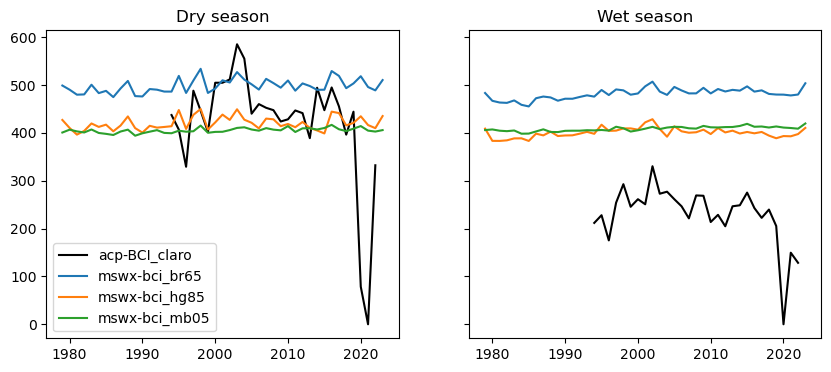

In [69]:
# dry season
pet_ds = merge_byindex([pd.read_csv(fnm, comment = "#", sep = " ", header = None, index_col = 0, names = [fnm[24:-4]]) for fnm in sorted(glob.glob("ts/panama_pet-dryseason_*.dat"))])
pet_ws = merge_byindex([pd.read_csv(fnm, comment = "#", sep = " ", header = None, index_col = 0, names = [fnm[24:-4]]) for fnm in sorted(glob.glob("ts/panama_pet-wetseason_*.dat"))]) / 2

fig, axs = plt.subplots(ncols = 2, figsize = (10,4), dpi = 100, sharey = True, sharex = True)

pet_ds[["acp-BCI_claro"]].plot(ax = axs[0], color = "k", legend = None)
pet_ds[[c for c in pet_ds.columns if "mswx-bci" in c]].plot(ax = axs[0], legend = None)
axs[0].set_title("Dry season")
axs[0].legend()

pet_ws[["acp-BCI_claro"]].plot(ax = axs[1], color = "k", legend = None)
pet_ws[[c for c in pet_ws.columns if "mswx-bci" in c]].plot(ax = axs[1], legend = None)

axs[1].set_title("Wet season")

## Precip
Validated against Barro Colorado Island station data: both Hargreaves and Baier-Robertson estimate dry-season PET reasonably well, but . Keep both of these in the final analysis.

In [78]:
# dry season
pr_ds = merge_byindex([pd.read_csv(fnm, comment = "#", sep = " ", header = None, index_col = 0, names = [fnm[23:-4]]) for fnm in sorted(glob.glob("ts/panama_pr-dryseason_*.dat"))])
pr_ws = merge_byindex([pd.read_csv(fnm, comment = "#", sep = " ", header = None, index_col = 0, names = [fnm[23:-4]]) for fnm in sorted(glob.glob("ts/panama_pr-wetseason_*.dat"))]) / 2

IndexError: list index out of range

In [ ]:
[pd.read_csv(fnm, comment = "#", sep = " ", header = None, index_col = 0, names = [fnm[23:-4]]) for fnm in sorted(glob.glob("ts/panama_pr-dryseason_*.dat"))]

In [80]:
sorted(glob.glob("ts/panama_pr-dryseason_*.dat"))

['ts/panama_pr-dryseason_acp-BCI.dat',
 'ts/panama_pr-dryseason_acp-GAMBOA.dat',
 'ts/panama_pr-dryseason_acp-long.dat',
 'ts/panama_pr-dryseason_acp-mid.dat',
 'ts/panama_pr-dryseason_acp-sat.dat',
 'ts/panama_pr-dryseason_chirps-bci.dat',
 'ts/panama_pr-dryseason_chirps-gamboa.dat',
 'ts/panama_pr-dryseason_chirps.dat',
 'ts/panama_pr-dryseason_mswep-bci.dat',
 'ts/panama_pr-dryseason_mswep-gamboa.dat',
 'ts/panama_pr-dryseason_mswep.dat']

Text(0.5, 1.0, 'Wet season')

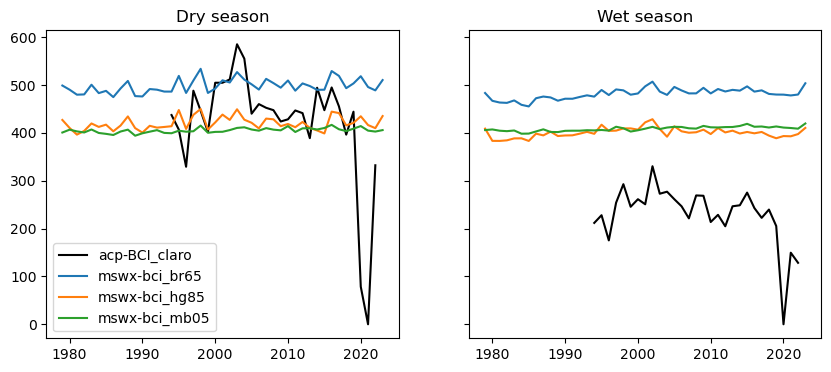

In [ ]:
fig, axs = plt.subplots(ncols = 2, figsize = (10,4), dpi = 100, sharey = True, sharex = True)

pet_ds[["acp-BCI_claro"]].plot(ax = axs[0], color = "k", legend = None)
pet_ds[[c for c in pet_ds.columns if "mswx-bci" in c]].plot(ax = axs[0], legend = None)
axs[0].set_title("Dry season")
axs[0].legend()

pet_ws[["acp-BCI_claro"]].plot(ax = axs[1], color = "k", legend = None)
pet_ws[[c for c in pet_ws.columns if "mswx-bci" in c]].plot(ax = axs[1], legend = None)

axs[1].set_title("Wet season")

---
# **Time series of anomalies over this region**

#### CHIRPS

In [27]:
chirps_ts = xr.open_dataset("data/chirps_panama_ts.nc").pr
chirps_clim_9020 = chirps_ts.sel(time = slice("1990", "2020")).groupby("time.dayofyear").mean()

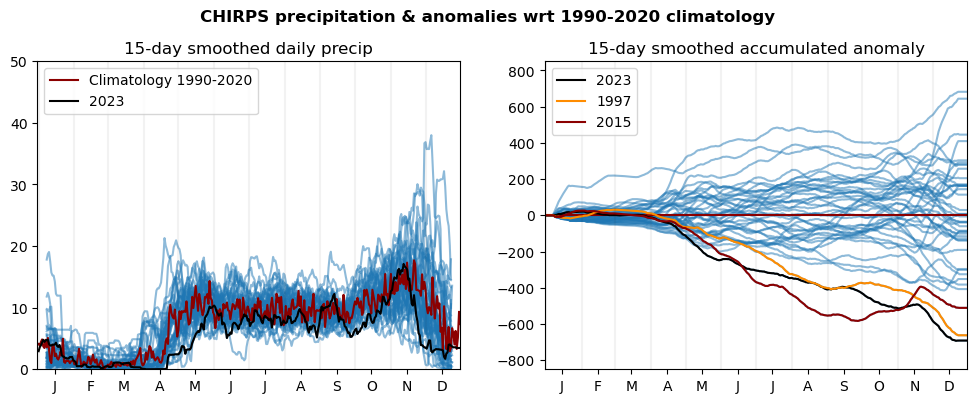

In [28]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def ts_fun(ts): return ts.rolling(time = 15, center = True).mean()
ax = axs[0]

for y in range(1981, 2024):
    ts_y = ts_fun(chirps_ts.sel(time = str(y)))
    ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5)
    
ax.plot(chirps_clim_9020.dayofyear, chirps_clim_9020, color = "darkred", label = "Climatology 1990-2020")
# ax.plot(clim_1020.dayofyear, clim_1020, color = "red")  # basically same as above

ts_y = ts_fun(chirps_ts).sel(time = str(2023))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k", label = "2023")
ax.set_title("15-day smoothed daily precip")
sc_xlabels(dates = chirps_ts.sel(time = "2000").time, ax = ax)

ax.legend(loc = "upper left")
ax.set_ylim(0,50)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# cumulative anomaly
def ts_fun(ts): return (ts.rolling(time = 15, center = True).mean() - chirps_clim_9020.values[:len(ts)]).cumsum()
ax = axs[1]

for y in range(1981, 2024):
    ts_y = ts_fun(chirps_ts.sel(time = str(y)))
    ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5)
    
ax.axhline(0, color = "darkred")
# ax.plot(chirps_clim_9020.dayofyear, chirps_clim_9020, color = "darkred")
# ax.plot(chirps_clim_1020.dayofyear, chirps_clim_1020, color = "red")  # basically same as above

ts_y = ts_fun(chirps_ts.sel(time = str(2023)))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k", label = "2023")

ts_y = ts_fun(chirps_ts.sel(time = str(1997)))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "darkorange", label = "1997")

ts_y = ts_fun(chirps_ts.sel(time = str(2015)))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "darkred", label = "2015")

ax.legend()
ax.set_title("15-day smoothed accumulated anomaly")
sc_xlabels(dates = chirps_ts.sel(time = "2000").time, ax = ax)
ax.set_ylim(-850,850)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for ax in axs:
    ax.set_xticks(labelticks); ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in gridlines]
    ax.set_xlabel("")
    ax.set_xlim(0,366)
    
plt.suptitle("CHIRPS precipitation & anomalies wrt 1990-2020 climatology", fontweight = "bold", y = 1.01)

plt.savefig("fig/chirps_anomaly-wrt-1990-2020.png")

- 2023 has been a dry year - however, not the driest on record - both 1997 and 2015 had a larger precipitation deficit by the end of August.  
- 2023 differs in that May and June were very dry; the last few months have been below average, but not catastrophically dry

#### MSWEP

In [26]:
mswep_ts = xr.open_dataset("data/mswep_panama_ts.nc").pr
mswep_clim_9020 = mswep_ts.sel(time = slice("1990", "2020")).groupby("time.dayofyear").mean()

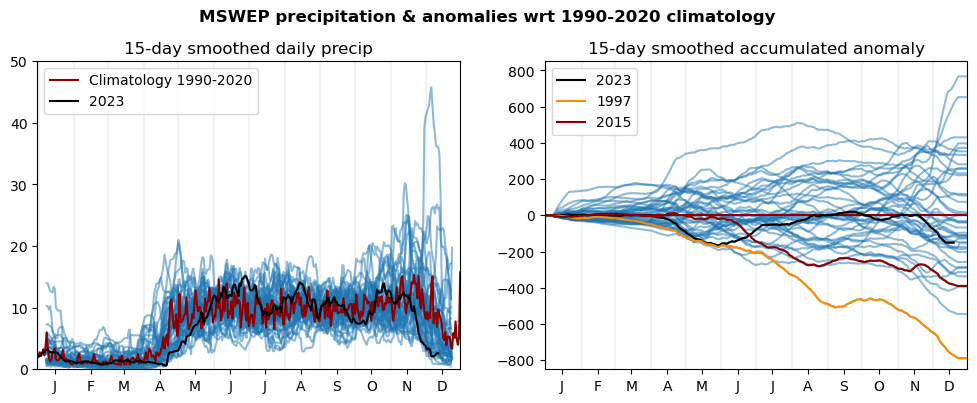

In [27]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def ts_fun(ts): return ts.rolling(time = 15, center = True).mean()
ax = axs[0]

for y in range(1981, 2024):
    ts_y = ts_fun(mswep_ts.sel(time = str(y)))
    ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5)
    
ax.plot(mswep_clim_9020.dayofyear, mswep_clim_9020, color = "darkred", label = "Climatology 1990-2020")
# ax.plot(mswep_clim_1020.dayofyear, mswep_clim_1020, color = "red")  # basically same as above

ts_y = ts_fun(mswep_ts).sel(time = str(2023))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k", label = "2023")
ax.set_title("15-day smoothed daily precip")
sc_xlabels(dates = mswep_ts.sel(time = "2000").time, ax = ax)

ax.legend(loc = "upper left")
ax.set_ylim(0,50)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# cumulative anomaly
def ts_fun(ts): return (ts.rolling(time = 15, center = True).mean() - mswep_clim_9020.values[:len(ts)]).cumsum()
ax = axs[1]

for y in range(1981, 2024):
    ts_y = ts_fun(mswep_ts.sel(time = str(y)))
    ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5)
    
ax.axhline(0, color = "darkred")
# ax.plot(mswep_clim_9020.dayofyear, mswep_clim_9020, color = "darkred")
# ax.plot(mswep_clim_1020.dayofyear, mswep_clim_1020, color = "red")  # basically same as above

ts_y = ts_fun(mswep_ts.sel(time = str(2023)))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k", label = "2023")

ts_y = ts_fun(mswep_ts.sel(time = str(1997)))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "darkorange", label = "1997")

ts_y = ts_fun(mswep_ts.sel(time = str(2015)))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "darkred", label = "2015")

ax.legend()
ax.set_title("15-day smoothed accumulated anomaly")
sc_xlabels(dates = mswep_ts.sel(time = "2000").time, ax = ax)
ax.set_ylim(-850,850)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for ax in axs:
    ax.set_xticks(labelticks); ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in gridlines]
    ax.set_xlabel("")
    ax.set_xlim(0,366)
    
plt.suptitle("MSWEP precipitation & anomalies wrt 1990-2020 climatology", fontweight = "bold", y = 1.01)

plt.savefig("fig/mswep_anomaly-wrt-1990-2020.png")

### Compare CHIRPS & MSWEP

In [ ]:
# removed ERA5l - very different to stations & other datasets
# era5l_ts = convert_units_to(xr.open_dataset("tmp.nc").tp.mean(["latitude", "longitude"]), "mm")

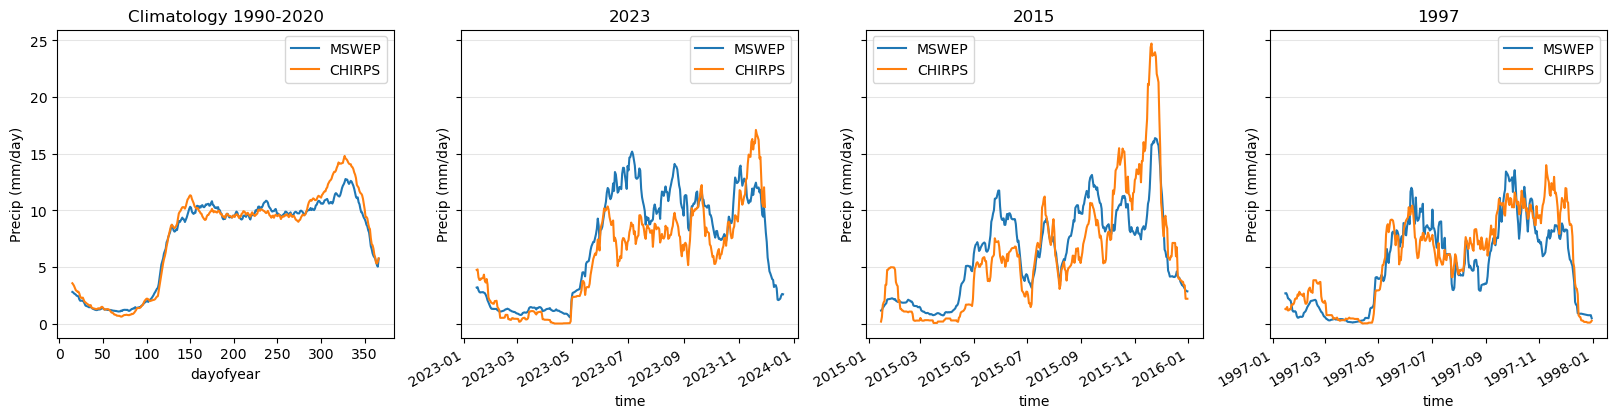

In [28]:
fig, axs = plt.subplots(ncols = 4, figsize = (20,4), dpi = 100, sharey = True)

# era5l_dat = era5l_ts.rolling(time = 15).mean()
# era5l_dat = era5l_dat.rename(time = "dayofyear")
# era5l_dat.plot(ax = axs[1], label = "ERA5-land", color = "tab:green")

for i in range(4):
    mswep_dat = ([mswep_clim_9020] + [mswep_ts.loc[str(y)].rename(time = "dayofyear") for y in [2023, 2015, 1997]])[i]
    chirps_dat = ([chirps_clim_9020] + [chirps_ts.loc[str(y)].rename(time = "dayofyear") for y in [2023, 2015, 1997]])[i]

    mswep_dat.rolling(dayofyear = 15).mean().plot(ax = axs[i], label = "MSWEP")
    chirps_dat.rolling(dayofyear = 15).mean().plot(ax = axs[i], label = "CHIRPS")
    axs[i].set_ylabel("Precip (mm/day)")
    
    axs[i].grid(color = "k", alpha = 0.1, axis = "y")
    axs[i].legend()

axs[0].set_title("Climatology 1990-2020")
axs[1].set_title("2023")
axs[2].set_title("2015")
axs[3].set_title("1997")

plt.savefig("fig/mswep-chirps-precipitation.png")

In [29]:
# smoothed climatology
chirps_clim_9020 = chirps_ts.rolling(time = 15).mean().sel(time = slice("1990", "2020")).groupby("time.dayofyear").mean()
mswep_clim_9020 = mswep_ts.rolling(time = 15).mean().sel(time = slice("1990", "2020")).groupby("time.dayofyear").mean()

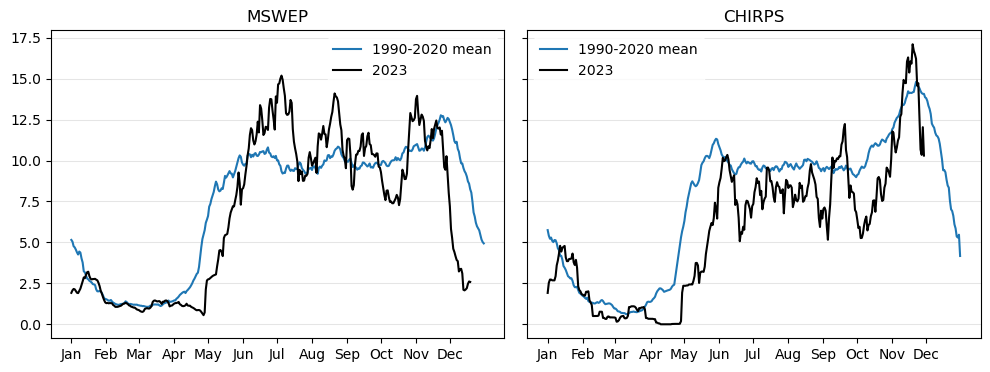

In [30]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100, sharey = True)
plt.subplots_adjust(wspace = 0.05)

for i in range(2):
    
    ax = axs[i]
    ts_clim = [mswep_clim_9020, chirps_clim_9020][i]
    ts_2023 = [mswep_ts, chirps_ts][i].rolling(time = 15).mean().loc["2023"].rename(time = "dayofyear")
    
    axs[i].grid(color = "k", alpha = 0.1, axis = "y")
    ax.plot(ts_clim, label = "1990-2020 mean")
    ax.plot(ts_2023, color = "k", label = "2023")
    
    ax.legend(edgecolor = "w")
    ax.set_title(["MSWEP", "CHIRPS"][i])
    
    sc_xlabels(dates = mswep_ts.sel(time = "2000").time, ax = ax)
    
axs[0].set_label("Precipitation (mm/day)")
plt.savefig("fig/precip-vs-climatology.png")

# Earlier noodlings

## **SPI**
Fitting done in R because Python parameter estimates can be unstable

In [32]:
mswep_spi = pd.read_csv("data/mswep_spi-monthly.csv", index_col = "time", parse_dates = ["time"])
chirps_spi = pd.read_csv("data/chirps_spi-monthly.csv", index_col = "time", parse_dates = ["time"])

In [33]:
nino34rel = decode_times(xr.open_dataset("../../Data/iersst_nino3.4a_rel.nc", decode_times = False))["Nino3.4r"].sel(time = slice("1950", "2023")).dropna("time", "any").to_dataframe()
nino34rel["nino1"] = nino34rel["Nino3.4r"].rolling(1, center = False).mean() 
nino34rel["nino3"] = nino34rel["Nino3.4r"].rolling(3, center = False).mean() 
nino34rel["nino6"] = nino34rel["Nino3.4r"].rolling(6, center = False).mean() 
nino34rel["nino12"] = nino34rel["Nino3.4r"].rolling(12, center = False).mean() 
nino34rel["nino24"] = nino34rel["Nino3.4r"].rolling(24, center = False).mean() 

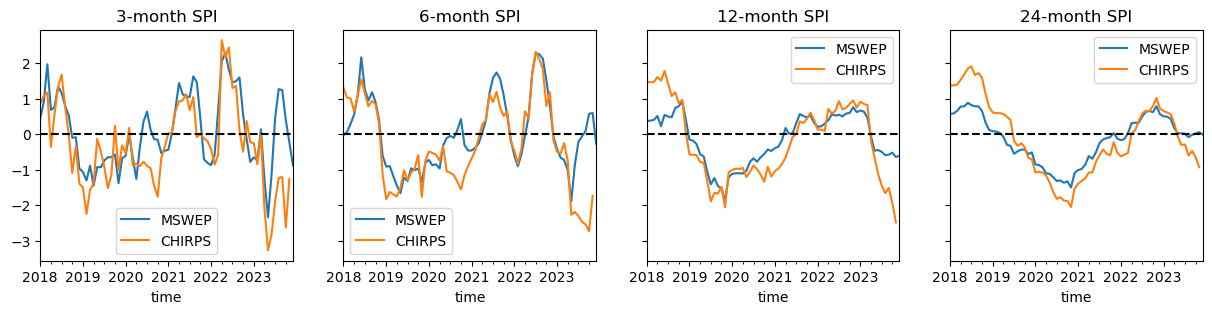

In [40]:
fig, axs = plt.subplots(ncols = 4, figsize = (15,3), dpi = 100, sharex = True, sharey = True) 
sl = slice("2018", None)

for i in range(4):
    nm = [3,6,12,24][i]
    ax = axs[i]
    mswep_spi.loc[sl]["spi_"+str(nm)].plot(ax = ax)
    chirps_spi.loc[sl]["spi_"+str(nm)].plot(ax = ax)
    # nino34rel.loc[slice("2010","2023")]["nino"+str(nm)].plot(ax = ax, color = "darkred", ls = "--", alpha = 0.5)

    ax.axhline(0, color = "k", ls = "--")
    ax.legend(["MSWEP", "CHIRPS"])
    ax.set_title(str(nm)+"-month SPI")
    
plt.savefig("fig/spi_panama_5year.png")

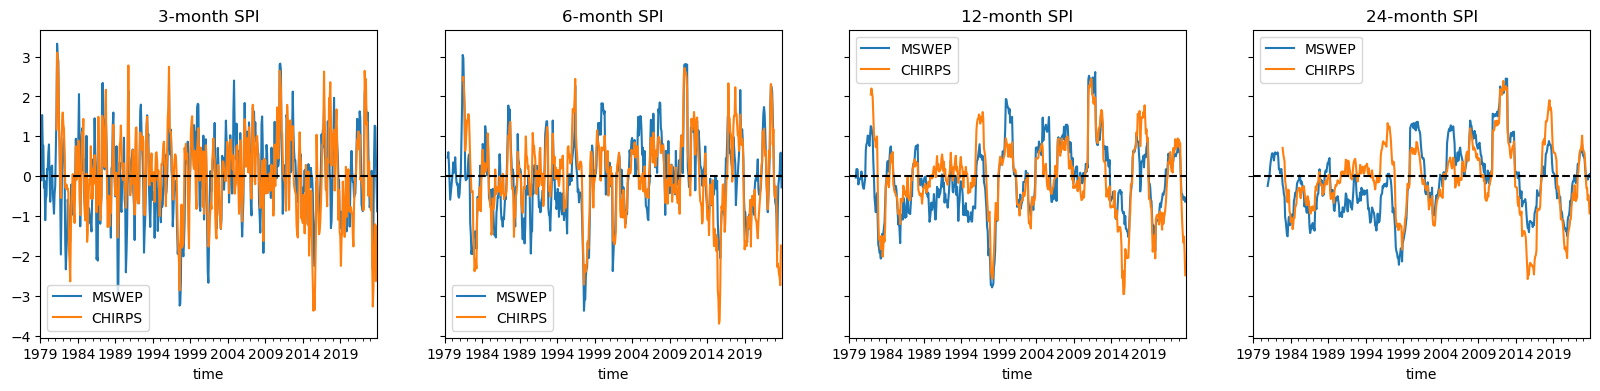

In [41]:
fig, axs = plt.subplots(ncols = 4, figsize = (20,4), dpi = 100, sharex = True, sharey = True) 
sl = slice(None, None)

for i in range(4):
    nm = [3,6,12,24][i]
    ax = axs[i]
    mswep_spi.loc[sl]["spi_"+str(nm)].plot(ax = ax)
    chirps_spi.loc[sl]["spi_"+str(nm)].plot(ax = ax)
    # nino34rel.loc[slice("2010","2023")]["nino"+str(nm)].plot(ax = ax, color = "darkred", ls = "--", alpha = 0.5)

    ax.axhline(0, color = "k", ls = "--")
    ax.legend(["MSWEP", "CHIRPS"])
    ax.set_title(str(nm)+"-month SPI")
    
plt.savefig("fig/spi_panama_trend.png")

### **Relationship with ENSO**

In [36]:
mswep_spi = pd.read_csv("data/mswep_spi-monthly.csv", index_col = "time", parse_dates = ["time"]).iloc[:,1:]
chirps_spi = pd.read_csv("data/chirps_spi-monthly.csv", index_col = "time", parse_dates = ["time"]).iloc[:,1:]

mswep_spi3 = mswep_spi.loc[mswep_spi.index.month == 12, "spi_3"].to_xarray().assign_coords(time = range(1979, 2024))
mswep_spi6 = mswep_spi.loc[mswep_spi.index.month == 12, "spi_6"].to_xarray().assign_coords(time = range(1979, 2024))
mswep_spi12 = mswep_spi.loc[mswep_spi.index.month == 12, "spi_12"].to_xarray().assign_coords(time = range(1979, 2024))
mswep_spi24 = mswep_spi.loc[mswep_spi.index.month == 12, "spi_24"].to_xarray().assign_coords(time = range(1979, 2024))

In [53]:
mswep_list = [mswep_spi.loc[mswep_spi.index.month == 12, "spi_"+str(nm)].to_xarray().rename(time = "year").assign_coords(year = range(1979, 2024))
              for nm in [3,6,12,24]]

In [49]:
nino34rel = decode_times(xr.open_dataset("data/iersst_nino3.4a_rel.nc", decode_times = False))["Nino3.4r"].sel(time = slice("1950", "2023")).dropna("time", "any")
nino34rel = xr.concat([nino34rel, nino34rel.isel(time = -1).expand_dims(time = [np.datetime64("2023-12-15")])], "time") # add dummy value for December 2023

In [54]:
def nino_rolling(agg, m): 
    nino = nino34rel.rolling(time = agg, center = False).mean().groupby("time.month")[m]
    nino = nino.assign_coords(time = nino.time.dt.year).rename(time = "year").sel(year = slice("1979", "2023"))
    return nino

In [56]:
print("Correlation with OND ENSO:")
print(merge_byindex([nino_rolling(3,12).to_dataframe()] + [da.to_dataframe() for da in mswep_list]).corr().iloc[0,1:])
print()
print("Correlation with 12-month ENSO:")
print(merge_byindex([nino_rolling(12,12).to_dataframe()] + [da.to_dataframe() for da in mswep_list]).corr().iloc[0,1:])
print()

Correlation with OND ENSO:
spi_3    -0.408668
spi_6    -0.544681
spi_12   -0.549013
spi_24   -0.362390
Name: Nino3.4r, dtype: float64

Correlation with 12-month ENSO:
spi_3    -0.387649
spi_6    -0.503018
spi_12   -0.517000
spi_24   -0.519233
Name: Nino3.4r, dtype: float64



In [71]:
nmonths = [3,6,12,18,24]
month_ending = list(range(13)[1:])

correlations = [xr.DataArray(data = np.array([[xr.concat([nino_rolling(agg, m), ts], "new").dropna("year", "any").to_pandas().transpose().corr().loc[0,1] for agg in nmonths] for m in month_ending]),
                             name = "corr", dims = ["month_ending", "nmonths"]).expand_dims(corr_with = [ts.name]) for ts in mswep_list]

correlations = xr.concat(correlations, "corr_with").assign_coords(month_ending = month_ending, nmonths = nmonths).transpose()

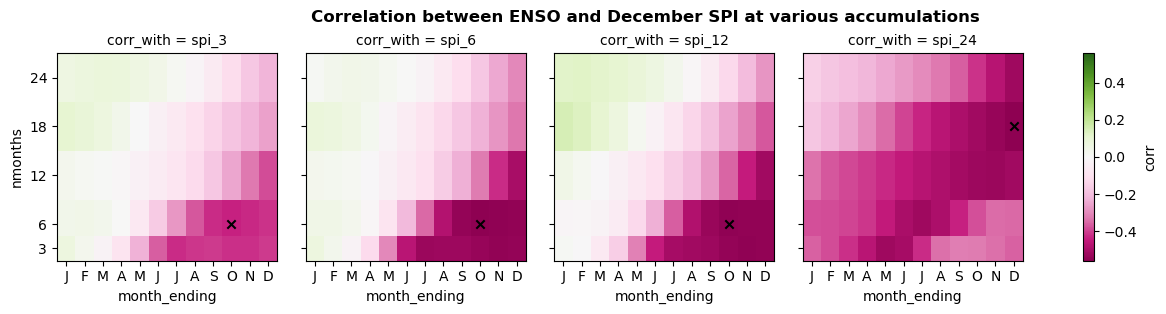

In [75]:
correlations.plot(col = "corr_with", cmap = "PiYG")

for ax in plt.gcf().axes[:-1]:
    ax.set_xticks([m + 1 for m in range(12)])
    ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"])
    ax.set_yticks(nmonths)
    
for i in range(4):
    ax = plt.gcf().axes[i]
    min_corr = correlations.isel(correlations.argmin(["month_ending", "nmonths"])).isel(corr_with = i)
    ax.scatter(min_corr.month_ending, min_corr.nmonths, marker = "x", color = "k")
    
plt.suptitle("Correlation between ENSO and December SPI at various accumulations", y = 1.03, fontweight = "bold")
    
plt.savefig("fig/nino-correlation-with-spi_mswep.png")

Text(0.5, 1.03, 'Relationship between JASOND Nino3.4 and accumulated SPI')

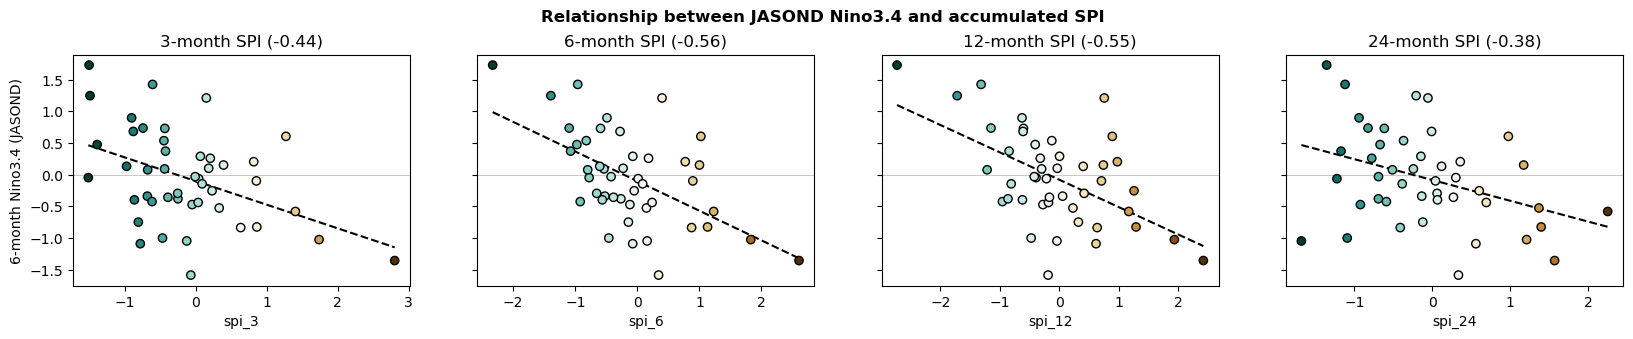

In [93]:
# correlation with 6-month SPI, MJJASO
fig, axs = plt.subplots(ncols = 4, figsize = (20,3), dpi = 100, sharey = True)

i = 0
ax = axs[i]
nm = 6; end = 10
rs_ts = mswep_list[0]
nino_ts = nino_rolling(nm,end)
cbar = ax.scatter(rs_ts, nino_ts, c = rs_ts, cmap = "BrBG_r", edgecolor = "k", zorder = 99)
xyline(rs_ts, nino_ts, ax = ax, ls = "--", color = "k")
ax.set_title("3-month SPI ("+str(round(np.corrcoef(rs_ts, nino_ts)[0,1], 2))+")")
ax.set_xlabel(rs_ts.name)
ax.set_ylabel("6-month Nino3.4 (JASOND)")

ax = axs[1]
rs_ts = mswep_list[1]
nino_ts = nino_rolling(nm,end)
cbar = ax.scatter(rs_ts, nino_ts, c = rs_ts, cmap = "BrBG_r", edgecolor = "k", zorder = 99)
xyline(rs_ts, nino_ts, ax = ax, ls = "--", color = "k")
ax.set_title("6-month SPI ("+str(round(np.corrcoef(rs_ts, nino_ts)[0,1], 2))+")")
ax.set_xlabel(rs_ts.name)

ax = axs[2]
rs_ts = mswep_list[2]
nino_ts = nino_rolling(nm,end)
cbar = ax.scatter(rs_ts, nino_ts, c = rs_ts, cmap = "BrBG_r", edgecolor = "k", zorder = 99)
xyline(rs_ts, nino_ts, ax = ax, ls = "--", color = "k")
ax.set_title("12-month SPI ("+str(round(np.corrcoef(rs_ts, nino_ts)[0,1], 2))+")")
ax.set_xlabel(rs_ts.name)

ax = axs[3]
rs_ts = mswep_list[3]
nino_ts = nino_rolling(nm,end)
cbar = ax.scatter(rs_ts, nino_ts, c = rs_ts, cmap = "BrBG_r", edgecolor = "k", zorder = 99)
xyline(rs_ts[~np.isnan(rs_ts)], nino_ts[~np.isnan(rs_ts)], ax = ax, ls = "--", color = "k")
ax.set_title("24-month SPI ("+str(round(np.corrcoef(rs_ts[~np.isnan(rs_ts)], nino_ts[~np.isnan(rs_ts)])[0,1], 2))+")")
ax.set_xlabel(rs_ts.name)

for ax in axs:
    ax.axhline(0, color = "k", alpha = 0.3, lw = 0.5)
    
plt.suptitle("Relationship between JASOND Nino3.4 and accumulated SPI", y = 1.03, fontweight = "bold")

Text(0.5, 1.03, 'Strongest observed relationship between Nino3.4 and December SPI')

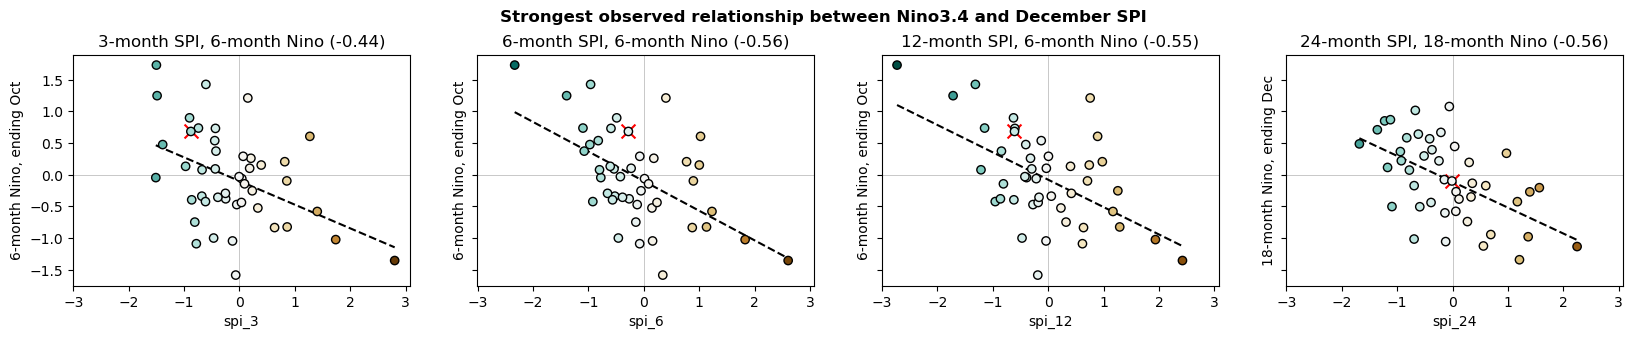

In [177]:
fig, axs = plt.subplots(ncols = 4, figsize = (20,3), dpi = 100, sharey = True, sharex = True)
plot_kwargs = {"cmap" : "BrBG_r", "edgecolor" : "k", "zorder" : 99, "vmin" : -3, "vmax" : 3}

for i in range(4):
    ax = axs[i]
    rs_ts = mswep_list[i]
    
    end,nm = [v.item()for v in list(correlations.isel(corr_with = i).isel(correlations.isel(corr_with = i).argmin(["month_ending", "nmonths"])).coords.values())[1:]]
    
    nino_ts = nino_rolling(nm, end)[~np.isnan(rs_ts)]
    rs_ts = rs_ts[~np.isnan(rs_ts)]
    corr = round(np.corrcoef(rs_ts, nino_ts)[0,1], 2)
    
    cbar = ax.scatter(rs_ts, nino_ts, c = rs_ts, **plot_kwargs)
    xyline(rs_ts, nino_ts, ax = ax, ls = "--", color = "k")
    ax.axhline(0, color = "k", alpha = 0.3, lw = 0.5)
    ax.axvline(0, color = "k", alpha = 0.3, lw = 0.5)
    
    ax.set_title(rs_ts.name.split("_")[-1]+"-month SPI, "+str(nm)+"-month Nino ("+str(corr)+")")
    ax.set_xlabel(rs_ts.name)
    ax.set_ylabel(str(nm)+"-month Nino, ending "+calendar.month_abbr[end])
    
    # nb. MSWEP doesn't have this recorded as a particularly dry year - better to repeat this with station data
    ax.scatter(rs_ts.sel(year = 2023), nino_ts.sel(year = 2023), marker = "x", color = "red", s = 100)
    
plt.suptitle("Strongest observed relationship between Nino3.4 and December SPI", y = 1.03, fontweight = "bold")

#### **Plots of SPI & ENSO**

In [43]:
nino34rel = decode_times(xr.open_dataset("../../Data/iersst_nino3.4a_rel.nc", decode_times = False))["Nino3.4r"].sel(time = slice("1950", "2023")).dropna("time", "any").to_dataframe()
nino34rel["nino1"] = nino34rel["Nino3.4r"].rolling(1, center = False).mean() 
nino34rel["nino3"] = nino34rel["Nino3.4r"].rolling(3, center = False).mean() 
nino34rel["nino6"] = nino34rel["Nino3.4r"].rolling(6, center = False).mean() 
nino34rel["nino12"] = nino34rel["Nino3.4r"].rolling(12, center = False).mean() 
nino34rel["nino24"] = nino34rel["Nino3.4r"].rolling(24, center = False).mean() 

nino34rel.to_csv("data/nino34rel_accum.csv")

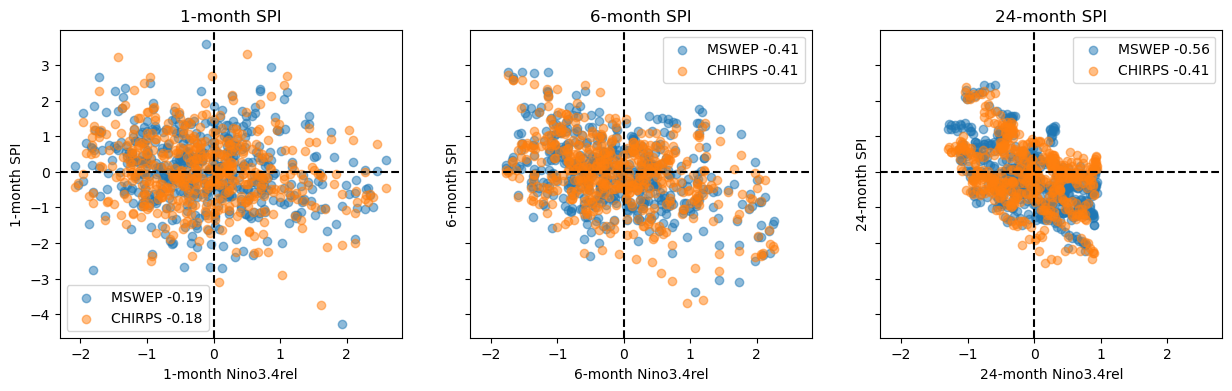

In [44]:
fig, axs = plt.subplots(ncols = 3, figsize = (15,4), dpi = 100, sharex = True, sharey = True) 

sl = slice("1983","2023-09")

for i in range(3):
    nm = [1,6,24][i]
    ax = axs[i]
    
    x = nino34rel.loc[sl]["nino"+str(nm)]
    y1 = mswep_spi.loc[sl]["spi_"+str(nm)]
    y2 = chirps_spi.loc[sl]["spi_"+str(nm)]
    
    ax.scatter(x, y1, alpha = 0.5)
    ax.scatter(x, y2, alpha = 0.5)

    ax.axhline(0, color = "k", ls = "--"); ax.axvline(0, color = "k", ls = "--")
    ax.legend(["MSWEP "+str(round(pearsonr(x, y1)[0], 2)),
               "CHIRPS "+str(round(pearsonr(x, y2)[0], 2))])
    
    ax.set_title(str(nm)+"-month SPI")
    ax.set_xlabel(str(nm)+"-month Nino3.4rel")
    ax.set_ylabel(str(nm)+"-month SPI")

plt.savefig("fig/spi-nino-correlatons.png")

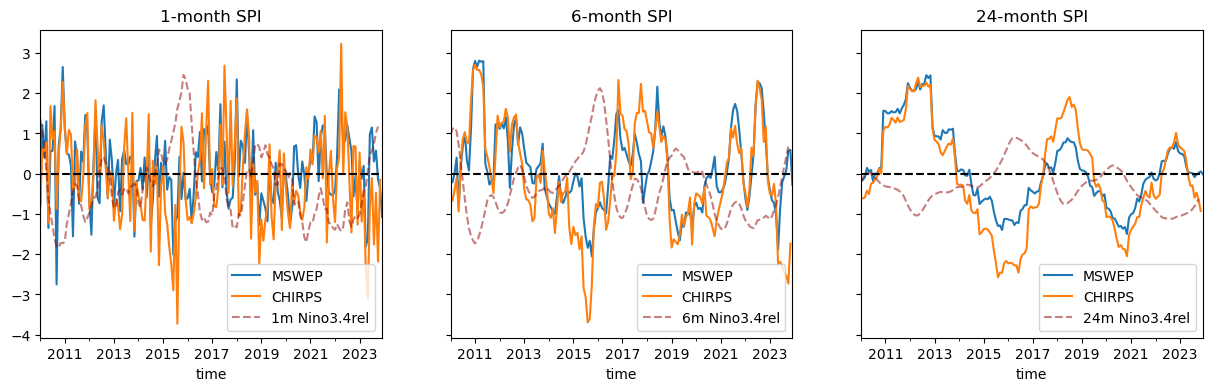

In [45]:
fig, axs = plt.subplots(ncols = 3, figsize = (15,4), dpi = 100, sharex = True, sharey = True) 

for i in range(3):
    nm = [1,6,24][i]
    ax = axs[i]
    mswep_spi.loc[slice("2010",None)]["spi_"+str(nm)].plot(ax = ax)
    chirps_spi.loc[slice("2010",None)]["spi_"+str(nm)].plot(ax = ax)
    nino34rel.loc[slice("2010","2023")]["nino"+str(nm)].plot(ax = ax, color = "darkred", ls = "--", alpha = 0.5)

    ax.axhline(0, color = "k", ls = "--")
    ax.legend(["MSWEP", "CHIRPS", str(nm)+"m Nino3.4rel"])
    ax.set_title(str(nm)+"-month SPI")
    
plt.savefig("fig/spi-nino_panama.png")

### **Correlation with lake levels**

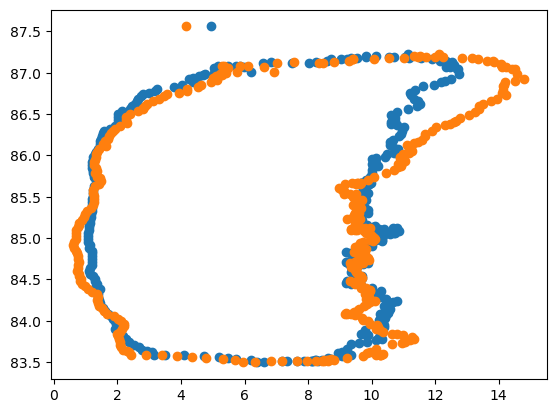

In [46]:
# not sure that this tells us much, but I like the shape
plt.scatter(mswep_clim_9020, df_clim)
plt.scatter(chirps_clim_9020, df_clim)

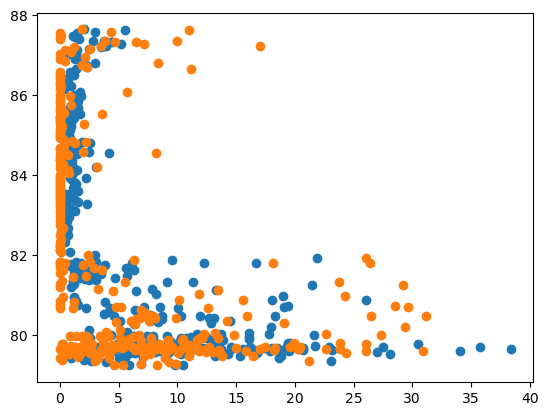

In [47]:
plt.scatter(mswep_ts.sel(time = df.loc["2023"].index), df.loc["2023"])
plt.scatter(chirps_ts.sel(time = "2023"), df.loc[chirps_ts.sel(time = "2023").time])

## **Temperature anomalies**

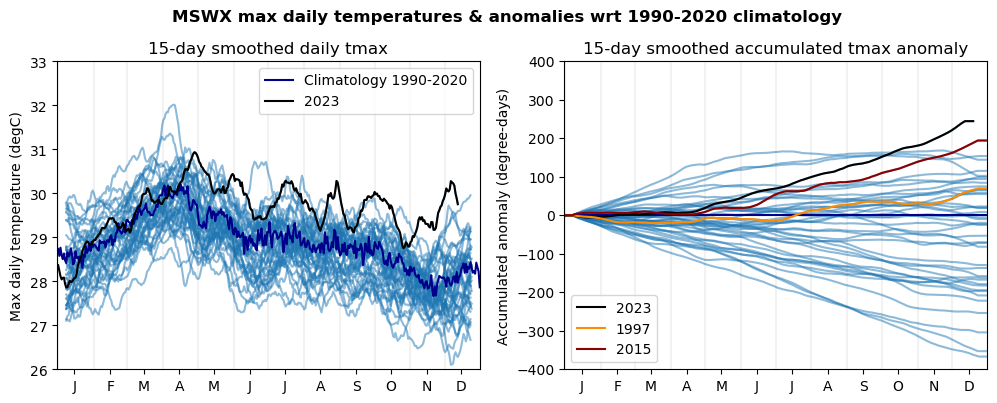

In [48]:
tmax_ts = xr.open_dataset("data/mswx-tmax_panama_ts.nc").tmax
tmax_clim_9020 = tmax_ts.sel(time = slice("1990", "2020")).groupby("time.dayofyear").mean()

fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def ts_fun(ts): return ts.rolling(time = 15, center = True).mean()
ax = axs[0]

for y in range(1981, 2024):
    ts_y = ts_fun(tmax_ts.sel(time = str(y)))
    ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5)
    
ax.plot(tmax_clim_9020.dayofyear, tmax_clim_9020, color = "darkblue", label = "Climatology 1990-2020")

ts_y = ts_fun(tmax_ts).sel(time = str(2023))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k", label = "2023")
ax.set_title("15-day smoothed daily tmax")
sc_xlabels(dates = tmax_ts.sel(time = "2000").time, ax = ax)

ax.legend()
ax.set_ylim(26,33)
ax.set_ylabel("Max daily temperature (degC)")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# cumulative anomaly
def ts_fun(ts): return (ts.rolling(time = 15, center = True).mean() - tmax_clim_9020.values[:len(ts)]).cumsum()
ax = axs[1]

for y in range(1981, 2024):
    ts_y = ts_fun(tmax_ts.sel(time = str(y)))
    ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5)
    
ax.axhline(0, color = "darkblue")
# ax.plot(chirps_clim_9020.dayofyear, chirps_clim_9020, color = "darkred")
# ax.plot(chirps_clim_1020.dayofyear, chirps_clim_1020, color = "red")  # basically same as above

ts_y = ts_fun(tmax_ts.sel(time = str(2023)))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k", label = "2023")

ts_y = ts_fun(tmax_ts.sel(time = str(1997)))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "darkorange", label = "1997")

ts_y = ts_fun(tmax_ts.sel(time = str(2015)))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "darkred", label = "2015")

ax.legend(loc = "lower left")
ax.set_title("15-day smoothed accumulated tmax anomaly")
sc_xlabels(dates = tmax_ts.sel(time = "2000").time, ax = ax)
ax.set_ylabel("Accumulated anomaly (degree-days)")
ax.set_ylim(-400,400)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for ax in axs:
    ax.set_xticks(labelticks); ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in gridlines]
    ax.set_xlabel("")
    ax.set_xlim(0,366)
plt.suptitle("MSWX max daily temperatures & anomalies wrt 1990-2020 climatology", fontweight = "bold", y = 1.01)

plt.savefig("fig/mswx-tmax_anomaly-wrt-1990-2020.png")

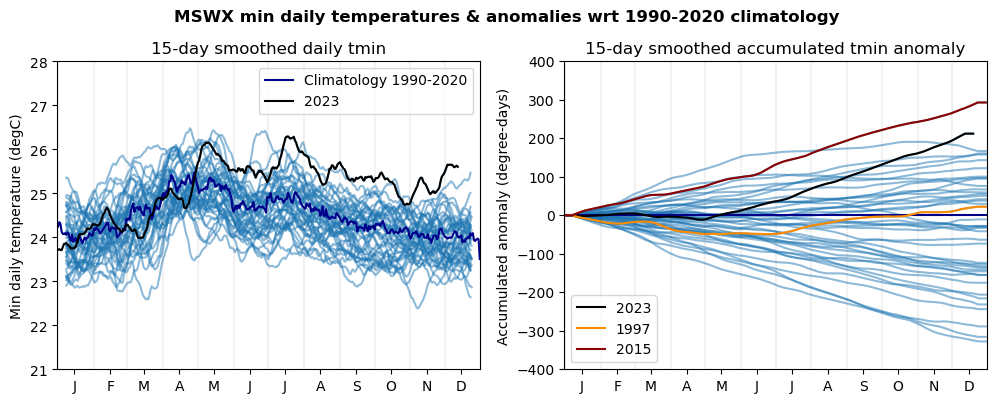

In [51]:
tmin_ts = xr.open_dataset("data/mswx-tmin_panama_ts.nc").tmin
tmin_clim_9020 = tmin_ts.sel(time = slice("1990", "2020")).groupby("time.dayofyear").mean()

fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def ts_fun(ts): return ts.rolling(time = 15, center = True).mean()
ax = axs[0]

for y in range(1981, 2024):
    ts_y = ts_fun(tmin_ts.sel(time = str(y)))
    ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5)
    
ax.plot(tmin_clim_9020.dayofyear, tmin_clim_9020, color = "darkblue", label = "Climatology 1990-2020")

ts_y = ts_fun(tmin_ts).sel(time = str(2023))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k", label = "2023")
ax.set_title("15-day smoothed daily tmin")
sc_xlabels(dates = tmin_ts.sel(time = "2000").time, ax = ax)

ax.legend()
ax.set_ylim(21,28)
ax.set_ylabel("Min daily temperature (degC)")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# cumulative anomaly
def ts_fun(ts): return (ts.rolling(time = 15, center = True).mean() - tmin_clim_9020.values[:len(ts)]).cumsum()
ax = axs[1]

for y in range(1981, 2024):
    ts_y = ts_fun(tmin_ts.sel(time = str(y)))
    ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5)
    
ax.axhline(0, color = "darkblue")
# ax.plot(chirps_clim_9020.dayofyear, chirps_clim_9020, color = "darkred")
# ax.plot(chirps_clim_1020.dayofyear, chirps_clim_1020, color = "red")  # basically same as above

ts_y = ts_fun(tmin_ts.sel(time = str(2023)))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k", label = "2023")

ts_y = ts_fun(tmin_ts.sel(time = str(1997)))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "darkorange", label = "1997")

ts_y = ts_fun(tmin_ts.sel(time = str(2015)))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "darkred", label = "2015")

ax.legend(loc = "lower left")
ax.set_title("15-day smoothed accumulated tmin anomaly")
sc_xlabels(dates = tmin_ts.sel(time = "2000").time, ax = ax)
ax.set_ylabel("Accumulated anomaly (degree-days)")
ax.set_ylim(-400,400)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for ax in axs:
    ax.set_xticks(labelticks); ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in gridlines]
    ax.set_xlabel("")
    ax.set_xlim(0,366)
plt.suptitle("MSWX min daily temperatures & anomalies wrt 1990-2020 climatology", fontweight = "bold", y = 1.01)

plt.savefig("fig/mswx-tmin_anomaly-wrt-1990-2020.png")

# **Station data**
Provided by Smithsonian Tropical Research Institute

## **Stations vs gridded products**

- ERA5-land values are very different to the station data, so won't be using it any further

In [64]:
acp_pr = pd.read_csv("data/acp_monthly-pr.csv", index_col = 0, parse_dates = [0])
acp_stations = pd.read_csv("data/acp_stations.csv", index_col = 0)
bci = pd.read_csv("data/bci_monthly.csv", index_col = 0, parse_dates = [0])[["pr"]].rename(columns = {"pr" : "BCI_STRI"})

# filter to show only currently active stations
acp_stations = acp_stations.loc[acp_stations.STATUS == "Active"]
acp_pr = acp_pr[[c for c in acp_pr.columns if c in acp_stations.index]]

# load gridded data
chirps = xr.open_dataset("data/chirps05_panama_monthly.nc").pr
mswep = xr.open_dataset("data/mswep_panama_monthly.nc").pr

# set period to compare
years = slice("1980", "2023")

### **Correlations at each site**

Text(0.5, 0.98, 'Correlation between gridded datasets & APC monthly precipitation (2000-2022)')

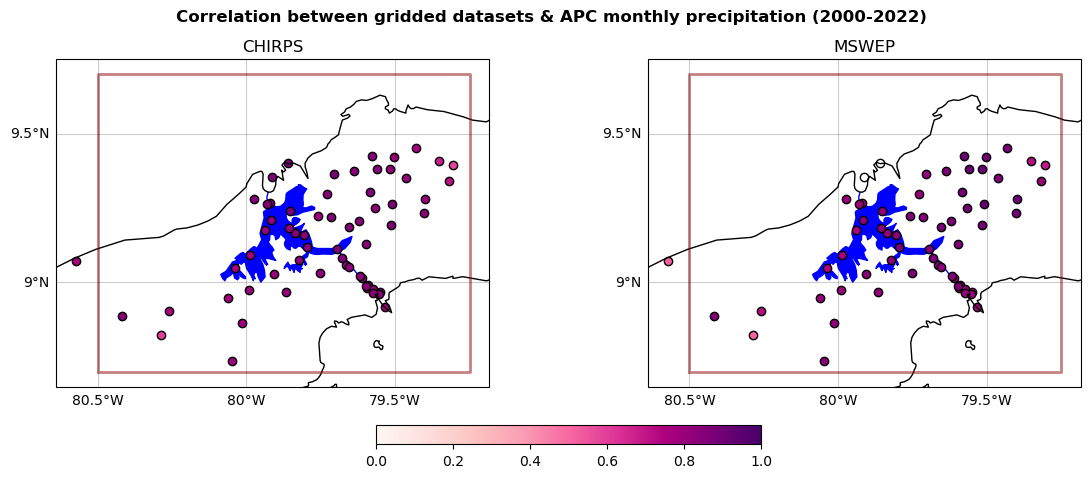

In [65]:
# map of correlations at each site

xn, xx, yn, yx = [-80.5,-79.25,8.7,9.7] # was originally -80.5

fig, axs = plt.subplots(ncols = 2, figsize = (14,5), subplot_kw = {"projection" : cproj}) #, "extent" : (xn, xx, yn, yx)})
plot_kwargs = {"edgecolor" : "k", "cmap" : "RdPu", "vmin" : 0, "vmax" : 1}

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAKES, color = "blue", zorder = -10)
    ax.add_feature(cartopy.feature.RIVERS, color = "blue", zorder = -10)
    ax.gridlines(color = "k", alpha = 0.2, draw_labels = ["left", "bottom"], xlocs = np.arange(np.floor(xn),xx+0.5,0.5), ylocs = np.arange(np.floor(yn),yx+0.5,0.5))
    ax.plot([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn], color = "darkred", lw = 2, alpha = 0.5)
        
for stn in acp_pr.columns:
    
    stn_px = acp_stations.loc[stn, ["lon", "lat"]]
    acp_ts = acp_pr[stn].loc[years]

    chirps_ts = chirps.sel(lon = stn_px.lon, lat = stn_px.lat, method = "nearest", drop = True).sel(time = years)
    mswep_ts = mswep.sel(lon = stn_px.lon, lat = stn_px.lat, method = "nearest", drop = True).sel(time = years)

    axs[0].scatter(stn_px.lon, stn_px.lat, c = merge_byindex([acp_ts, chirps_ts.to_dataframe()]).corr()["pr"][0], **plot_kwargs)
    cbar = axs[1].scatter(stn_px.lon, stn_px.lat, c = merge_byindex([acp_ts, mswep_ts.to_dataframe()]).corr()["pr"][0], **plot_kwargs)

plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.05, pad = 0.1)
axs[0].set_title("CHIRPS")
axs[1].set_title("MSWEP")

plt.suptitle("Correlation between gridded datasets & APC monthly precipitation (2000-2022)", fontweight = "bold")

### **Panama precip**

In [66]:
acp_panama = acp_pr.mean(axis = 1).loc[years]
chirps_panama, mswep_panama = [da.mean(["lat", "lon"]) for da in [chirps, mswep]]

#### **Mean over region**

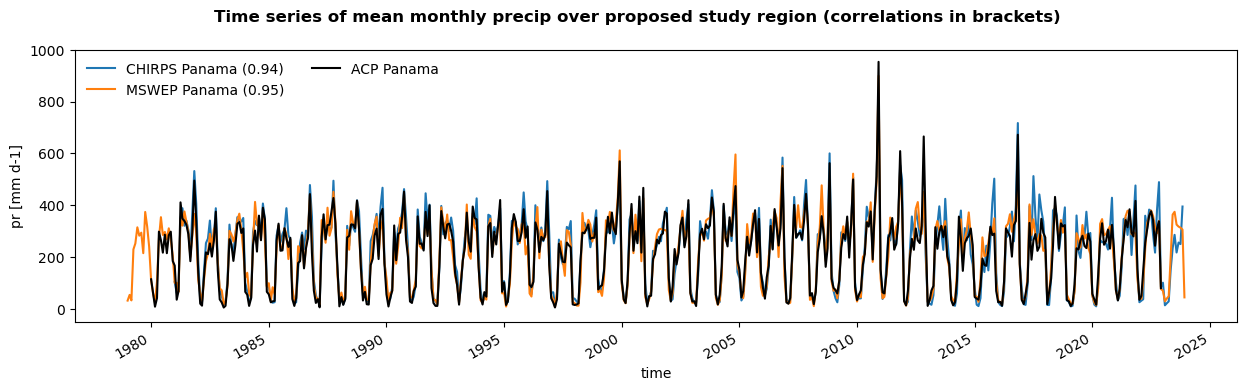

In [67]:
# high correlations between active gridded stations & observations when averaged over the whole region
plt.subplots(figsize = (15,4))

chirps_panama.plot(label = "CHIRPS Panama ("+str(round(merge_byindex([pd.DataFrame(acp_panama), chirps_panama.to_dataframe()]).corr()["pr"][0], 2))+")")
mswep_panama.plot(label = "MSWEP Panama ("+str(round(merge_byindex([pd.DataFrame(acp_panama), mswep_panama.to_dataframe()]).corr()["pr"][0], 2))+")")
acp_panama.loc[years].plot(color = "k", label = "ACP Panama")

plt.legend(loc = "upper left", ncols = 2, edgecolor = "w")
plt.ylim(-50,1000)
plt.suptitle("Time series of mean monthly precip over proposed study region (correlations in brackets)", fontweight = "bold")
plt.savefig("fig/gridded-vs-station_Panama.png")

### **Lake Gatun precip**

In [68]:
# filter again to show only sites over Lake Gatun
gatun_sites = ["AGUASALUD","BCI","BARBACOA","CANO","CERROCAMA","CHORRO","FRIJOLITO","GAMBOA","GATUN",
               "GUACHA","HUMEDAD","ISLABRUJA","PUNTAFRIJOLES","RAICES","VALLEGATUN","ZANGUENGA"]
acp_pr = acp_pr[[c for c in acp_pr.columns if c in gatun_sites]]

# smaller region focussed on Lake Gatun
xn, xx, yn, yx = [-80.1,-79.6,8.9,9.4]
    
chirps_gatun, mswep_gatun = [da.sel(lon = slice(xn, xx), lat = slice(yn, yx)).mean(["lat", "lon"]) for da in [chirps, mswep]]
acp_gatun = acp_pr.mean(axis = 1)

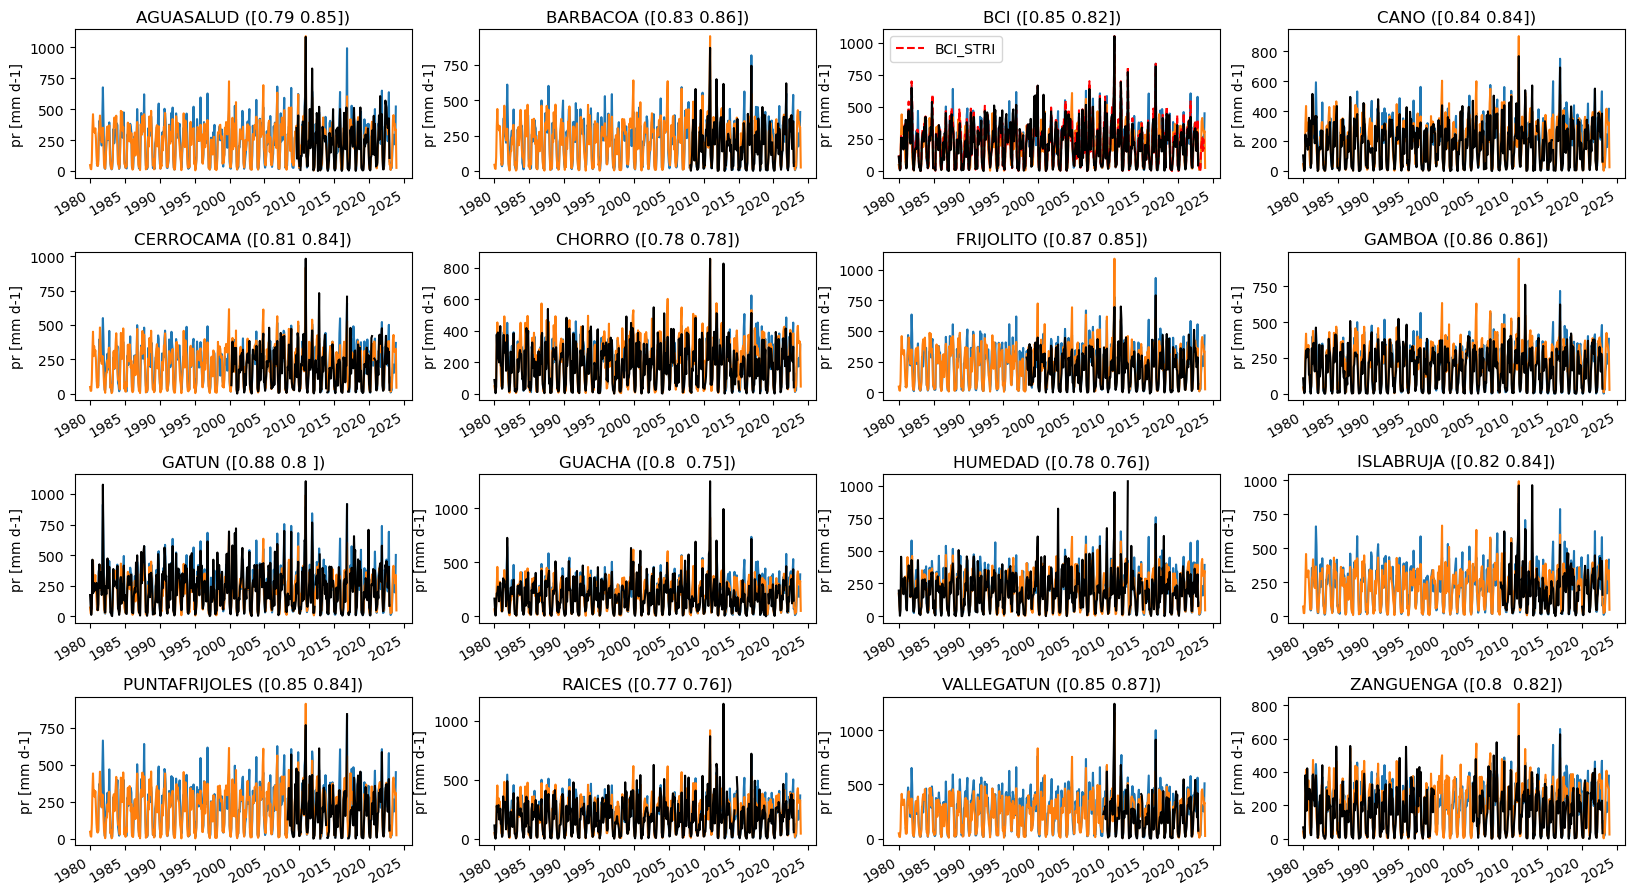

In [69]:
fig, axs = plt.subplots(ncols = 4, nrows = 4, figsize = (20,12), dpi = 100)
plt.subplots_adjust(hspace = 0.5)

for i in range(16):
    ax = fig.axes[i]
    stn = acp_pr.columns[i]
    
    stn_px = acp_stations.loc[stn, ["lon", "lat"]]

    [chirps_ts, mswep_ts] = [ts.sel(lon = stn_px.lon, lat = stn_px.lat, method = "nearest", drop = True).sel(time = years) for ts in [chirps, mswep]]
    acp_ts = acp_pr[stn].loc[years]
    site_corrs = round(pd.merge(acp_ts, xr.merge([chirps_ts.rename("chirps"), mswep_ts.rename("mswep")]).to_pandas(), left_index = True, right_index = True).corr()[stn][1:], 2)
    
    chirps_ts.plot(ax = ax, label = "CHIRPS")
    mswep_ts.plot(ax = ax, label = "MSWEP")
    # era5l_ts.plot(ax = ax, label = "ERA5-land") # bonkers numbers, so removing
    if stn == "BCI" : bci.loc[years].plot(ax = ax, color = "red", label = "STRI", ls = "--")
    acp_ts.plot(ax = ax, color = "k", label = "ACP")

    # ax.legend()
    ax.set_xlabel("")
    ax.set_title(stn + " (" + str(str(site_corrs.values))+")")

#### **Correlations at each site**

Text(0.5, 0.98, 'Correlation between gridded datasets & APC monthly precipitation (2000-2022)')

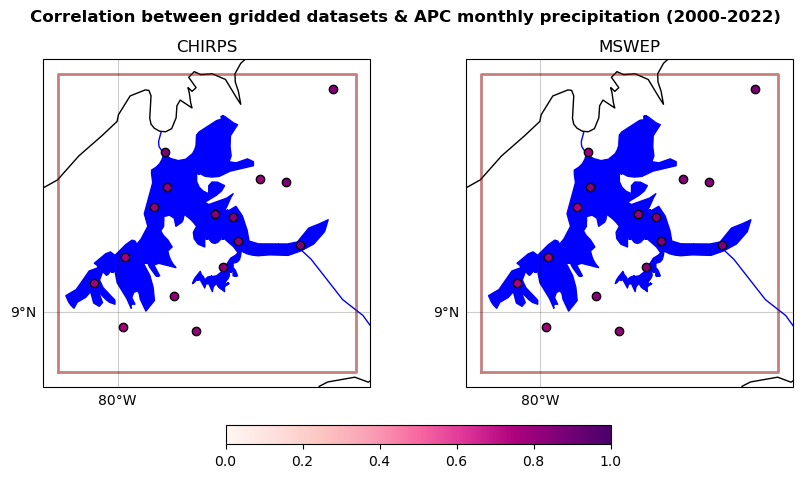

In [70]:
# map of correlations at each site
fig, axs = plt.subplots(ncols = 2, figsize = (10,5), subplot_kw = {"projection" : cproj})
plot_kwargs = {"edgecolor" : "k", "cmap" : "RdPu", "vmin" : 0, "vmax" : 1}

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAKES, color = "blue", zorder = -10)
    ax.add_feature(cartopy.feature.RIVERS, color = "blue", zorder = -10)
    ax.gridlines(color = "k", alpha = 0.2, draw_labels = ["left", "bottom"], xlocs = np.arange(np.floor(xn),xx+0.5,0.5), ylocs = np.arange(np.floor(yn),yx+0.5,0.5))
    ax.plot([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn], color = "darkred", lw = 2, alpha = 0.5)

for stn in acp_pr.columns:
    
    stn_px = acp_stations.loc[stn, ["lon", "lat"]]
    acp_ts = acp_pr[stn].loc[years]

    chirps_ts = chirps.sel(lon = stn_px.lon, lat = stn_px.lat, method = "nearest", drop = True).sel(time = years)
    mswep_ts = mswep.sel(lon = stn_px.lon, lat = stn_px.lat, method = "nearest", drop = True).sel(time = years)

    axs[0].scatter(stn_px.lon, stn_px.lat, c = merge_byindex([acp_ts, chirps_ts.to_dataframe()]).corr()["pr"][0], **plot_kwargs)
    cbar = axs[1].scatter(stn_px.lon, stn_px.lat, c = merge_byindex([acp_ts, mswep_ts.to_dataframe()]).corr()["pr"][0], **plot_kwargs)

plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.05, pad = 0.1)
axs[0].set_title("CHIRPS")
axs[1].set_title("MSWEP")

plt.suptitle("Correlation between gridded datasets & APC monthly precipitation (2000-2022)", fontweight = "bold")

#### **Mean over region**

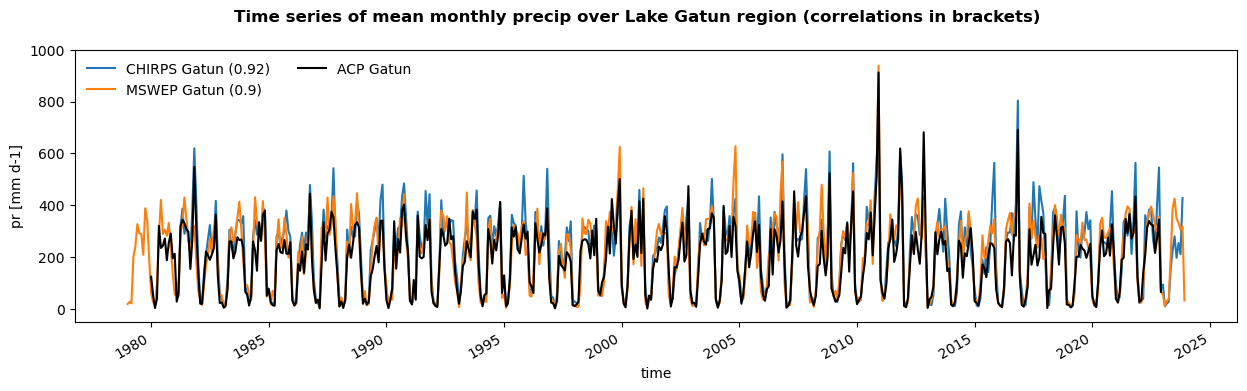

In [71]:
plt.subplots(figsize = (15,4))

chirps_gatun.plot(label = "CHIRPS Gatun ("+str(round(merge_byindex([pd.DataFrame(acp_gatun), chirps_gatun.to_dataframe()]).corr()["pr"][0], 2))+")")
mswep_gatun.plot(label = "MSWEP Gatun ("+str(round(merge_byindex([pd.DataFrame(acp_gatun), mswep_gatun.to_dataframe()]).corr()["pr"][0], 2))+")")
# bci.loc[slice("1980", "2023")].plot(ax = plt.gca(), color = "red", ls = "--")
acp_gatun.loc[slice("1980", "2023")].plot(color = "k", label = "ACP Gatun")

plt.legend(loc = "upper left", ncols = 2, edgecolor = "w")
plt.ylim(-50,1000)
plt.suptitle("Time series of mean monthly precip over Lake Gatun region (correlations in brackets)", fontweight = "bold")
plt.savefig("fig/gridded-vs-station_Gatun.png")

#### **How representative is regional mean of lake Gatun?**

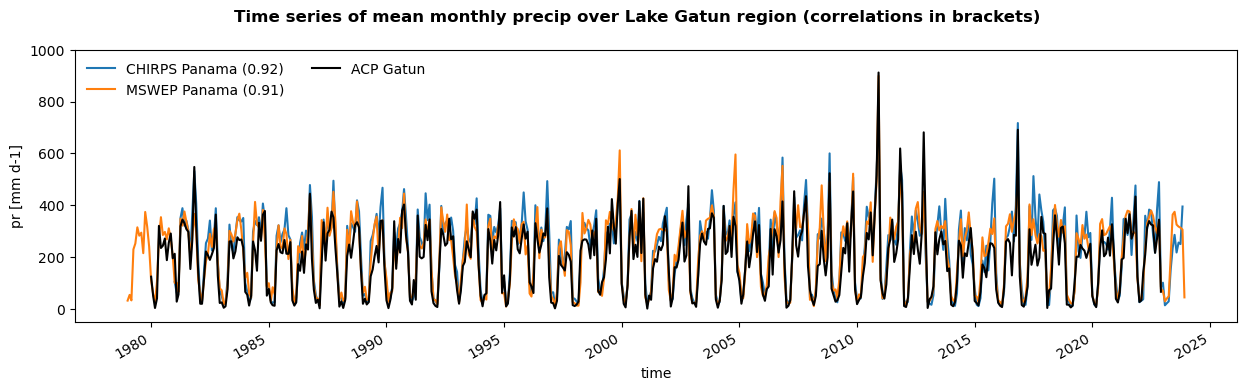

In [72]:
plt.subplots(figsize = (15,4))

chirps_panama.plot(label = "CHIRPS Panama ("+str(round(merge_byindex([pd.DataFrame(acp_gatun), chirps_panama.to_dataframe()]).corr()["pr"][0], 2))+")")
mswep_panama.plot(label = "MSWEP Panama ("+str(round(merge_byindex([pd.DataFrame(acp_gatun), mswep_panama.to_dataframe()]).corr()["pr"][0], 2))+")")
acp_gatun.loc[slice("1980", "2023")].plot(color = "k", label = "ACP Gatun")

plt.legend(loc = "upper left", ncols = 2, edgecolor = "w")
plt.ylim(-50,1000)
plt.suptitle("Time series of mean monthly precip over Lake Gatun region (correlations in brackets)", fontweight = "bold")
plt.savefig("fig/gridded-vs-station_Panama_Gatun.png")

# **Onset, end & duration of wet season**

## **Define rainy season**

The method is based on that used by [Bombardi et al (2017), B017](https://journals.ametsoc.org/view/journals/bams/100/7/bams-d-18-0177.1.xml), which is in turn based on an approach proposed by [Liebmann and Marengo (2001), LM01](https://journals.ametsoc.org/view/journals/bams/100/7/bams-d-18-0177.1.xml#bib28). From [Bombardi et al (2017)](https://journals.ametsoc.org/view/journals/bams/100/7/bams-d-18-0177.1.xml): 

This method uses only precipitation data and calculates the timing of the rainy (or dry) season at the local scale (e.g., station or grid point) based on accumulated precipitation anomalies
$ S=\sum_{i-t_0}(p_i - \bar{p})$,  
where $p_i$ is the daily precipitation rate on day $i$, $\bar{p}$ is the long-term mean annual precipitation rate in mm/day, and $t_0$ is the starting date for the calculations.


If we want to calculate the onset date of the rainy (or demise date of the dry) season, we start the calculation of $S$ well within the dry season. Therefore, $S$ will initially assume negative values. Once the rainy season starts, there will be an inflection in $S$. The inflection point is considered the onset date of the rainy season. For regions that experience well-defined rainy seasons, the date of inflection of the $S$ curve does not depend on $t_0$, as long as $t_0$ is reasonably well defined.

- $t_0$ is defined as the date of the minimum of the first harmonic of the mean annual cycle of precipitation at each grid point. This ensures that the calculation of the onset and demise dates start half a year from the peak date of the rainy season.

- the demise date of the rainy season is defined almost exactly how we define the onset date, the only difference being that we calculate demise dates retrospectively. That is, we start the calculation of $S$ at date $t_0$ (well within the dry season) and move back in time.

-  for most years, especially in monsoonal regions, finding the inflection point is as straightforward as finding the date of minimum accumulated precipitation anomalies. Therefore, the first step consists of calculating the timing of the rainy season using the original method. However, in some years, the rainy season evolves so gradually that the dates of the minimum or maximum in the time series of accumulated precipitation anomalies are ambiguous. For such years, the algorithm tends to fail to detect the onset or demise dates or detect them too early or too late in comparison to the climatology. Therefore, after calculating the onset and demise dates, we check for outliers. Outliers are defined as cases when the onset or demise dates are below or above 1.5 times the interquartile range. Then we perform the second step, which consists of recalculating the timing of the rainy season for the cases detected as outliers. For these few cases, we determine the timing of the rainy season based on the methodology described in B017. That means that we detect the dates of onset or demise by smoothing $S$ and taking the first derivative (with respect to time) of the smoothed $S$ curve. The first day when the derivative changes sign and persists for 3 days is considered the onset (or demise) date of the rainy season. The $S$ curve is smoothed using a 1–2–1 filter passed 50 times. The smoothing in this second pass is necessary to avoid detecting false onset (or demise) dates. Finally, we check again for outliers as dates above or below 3 times (less strict than the first check) the interquartile range. If both methods fail, the data point is considered missing data. We also mask regions where the algorithm fails to detect the onset or demise dates more than 33% of the time. Note that in this work the demise dates were calculated retrospectively.

In [232]:
# functions originally devised for West Africa drought study
import xclim

def anom_diff_ts(ts, sm = 15, t0 = 0):
    
    # t0 is start of year used for accumulation of anomalies (should be in middle of dry season - default is to start from beginning of calendar year)
    # sm is number of days used to smooth the anomalies (default is 15, ie day +- 7 days)
    
    # wrap year at t0 by shifting all values forwards
    ts = ts.shift(time = -t0)
    
    # daily anomaly wrt annual mean
    anom = ts.groupby("time.year") - ts.groupby("time.year").mean("time")
       
    # cumulative daily anomalies each year
    anom_cum = anom.groupby("time.year").cumsum()
    
    # smooth the cumulative anomalies
    anom_sm = anom_cum.rolling(time = sm, center = True).mean()
    
    # differences of smoothed anomalies
    anom_diff = anom_sm.diff("time")
    
    # push the anomalies back to have the correct dates
    anom_diff = anom_diff.shift(time = t0)
    
    return anom_diff

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

def rainy_season(ts, sm = 15, t0 = 0, longest_run = True):
        
    # get differences of smoothed anomalies; adjust time to get cutpoints in right place
    anom_ts = anom_diff_ts(ts, sm = sm, t0 = t0)
    anom_ts = anom_ts.shift(time = -t0)
    
    if longest_run:
        # only include the single longest wet period
        
        # count number of consecutive days of positive gradient in cumulative precip
        rs_length = xclim.indices.run_length.rle(xr.ones_like(anom_ts).where(anom_ts > 0, 0))
        
        # tag all days with length of period to which they belong
        rs_length = rs_length.ffill("time")
        
        # identify those days that are part of the longest wet period in each year
        rs = rs_length.where(rs_length.groupby("time.year") - rs_length.groupby("time.year").max() == 0)
    
    else:
        # include all days with positive gradient as part of wet season
        rs = anom_ts.where(anom_ts > 0)
        
    # convert calendar to Gregorian, matching dates (necessary when working with climate model data)
    rs = xclim.core.calendar.convert_calendar(rs, "default", align_on = "date")
    
    # get start & end of rainy season; adjust time to get cutpoints in right place
    onsets = rs.time.where(rs > 0).dropna("time", "any").groupby("time.year").min().dt.dayofyear.rename("rs_onset") + t0
    ends = rs.time.where(rs > 0).dropna("time", "any").groupby("time.year").max().dt.dayofyear.rename("rs_end") + t0
    
    # duration of rainy season
    durations = (ends - onsets).rename("rs_duration")
    
    return onsets, ends, durations

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def rs_intensity(ts, onsets, ends):
    
    rs_intensity = []
    for y in list(set(ts.time.dt.year.values)):
        ts_y = ts.sel(time = str(y))
        rs = ts_y.sel(time = [(d >= onsets.sel(year = y)) & (d <= ends.sel(year = y)) for d in ts_y.time.dt.dayofyear])
        rs_intensity.append(rs.mean("time").expand_dims(year = [y]))
    rs_intensity = xr.concat(rs_intensity, "year").rename("rs_intensity")
    return rs_intensity

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

def anom_plot(ts, sm = 15, t0 = 0, **kwargs):
    
    # quick plotting function to establish parameters
    anom = anom_diff_ts(ts, sm = sm, t0 = t0)
    anom.plot(**kwargs)
    [plt.axvline(t, color = "magenta", ls = "--") for t in anom.groupby("time.dayofyear")[t0].time.values]
    plt.axhline(0, color = "k", ls = "--")

In [233]:
# test method on gridded data
mswep = xr.open_dataset("data/mswep_panama_ts.nc").pr

In [234]:
# assume that year starts on day 50 (should be in middle of dry season)
sm = 15; t0 = 50

anom_plot(mswep.sel(time = slice("2018", None)), sm = sm, t0 = t0, figsize = (10,4))
# rainfall during wet season is v variable but dry season is quite clearly defined - either use a longer smooth (eg 31 days) or (preferable) don't only consider the longest run

In [595]:
# note: rainy season may end in next year, in which case 'ends' will be greater than 366
onsets, ends, durations = rainy_season(mswep, sm = sm, t0 = t0, longest_run = False)
intensities = rs_intensity(mswep, onsets, ends)
accumulations = intensities * durations

### **Time series**

In [604]:
variables = {"onsets" : {"units" : "days", "desc" : "onset of rainy season"},
             "ends" : {"units" : "days", "desc" : "end of rainy season"},
             "durations" : {"units" : "days", "desc" : "duration of rainy season"},
             "intensities" : {"units" : "mm/day", "desc" : "mean daily precipitation rate during rainy season"},
             "accumulation" : {"units" : "mm", "desc" : "total precipitation during rainy season"}}

for vnm in variables.keys():
    
    ts = eval(vnm)

    csv_fnm = "panama-drought_mswep_rs-"+vnm
    csv_fullpath = "ts/"+csv_fnm+".dat"
    
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
    
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: MSWEP rainy season "+vnm+" Panama drought 2023-4, c.barnes22@imperial.ac.uk"
    str2 = "# rs_"+vnm+" ["+variables[vnm]["units"]+"] "+variables[vnm]["desc"]+" over central Panama at "+csv_fnm
    head = "# year rs_"+vnm
    
    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    ts.to_pandas().to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

## **Characteristics of rainy season**

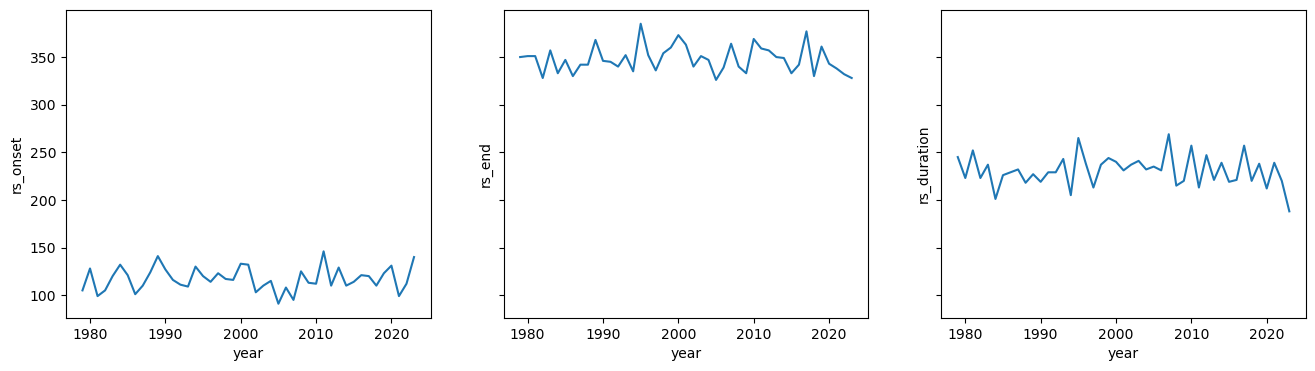

In [240]:
fig, axs = plt.subplots(ncols = 3, figsize = (16,4), dpi = 100, sharey = True)
onsets.plot(ax = axs[0])
ends.plot(ax = axs[1])
durations.plot(ax = axs[2])

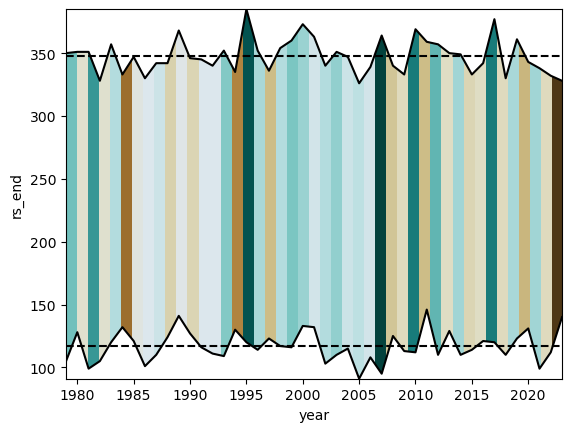

In [370]:
onsets.plot(color = "k")
ax = plt.gca()
ends.plot(ax = ax, color = "k")
fill_shape = ax.fill_between(x = onsets.year, y1 = onsets, y2 = ends, alpha = 0.1, cmap = "Blues")

ax.axhline(onsets.mean(), color = "k", ls = "--")
ax.axhline(ends.mean(), color = "k", ls = "--")

verts = np.vstack([p.vertices for p in fill_shape.get_paths()])

filling = ax.imshow(durations.values.reshape(1, -1), cmap='BrBG', aspect='auto',
                    extent=[verts[:, 0].min(), verts[:, 0].max(), verts[:, 1].min(), verts[:, 1].max()])
filling.set_clip_path(fill_shape.get_paths()[0], transform = ax.transData)

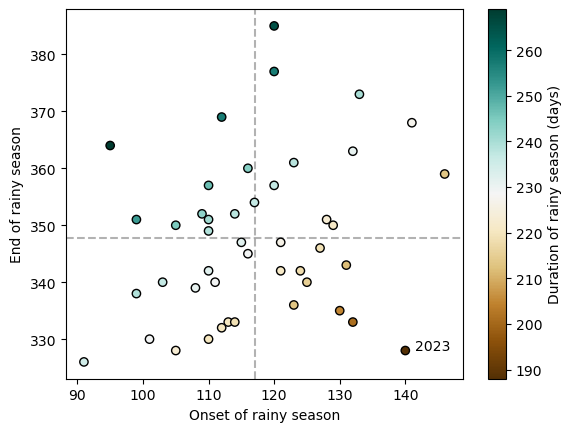

In [395]:
cbar = plt.scatter(onsets, ends, c = durations, cmap = "BrBG", edgecolor = "k", zorder = 99)
plt.xlabel("Onset of rainy season")
plt.ylabel("End of rainy season")
plt.colorbar(cbar, label = "Duration of rainy season (days)")
plt.axhline(ends.mean(), color = "k", ls = "--", alpha = 0.3)
plt.axvline(onsets.mean(), color = "k", ls = "--", alpha = 0.3)

plt.text(onsets.sel(year = 2023).values+1.5, ends.sel(year = 2023).values, "2023")

plt.savefig("fig/rainy-season-characteristics_mswep.png")

Text(0.5, 1.0, 'Intensity of rainy season')

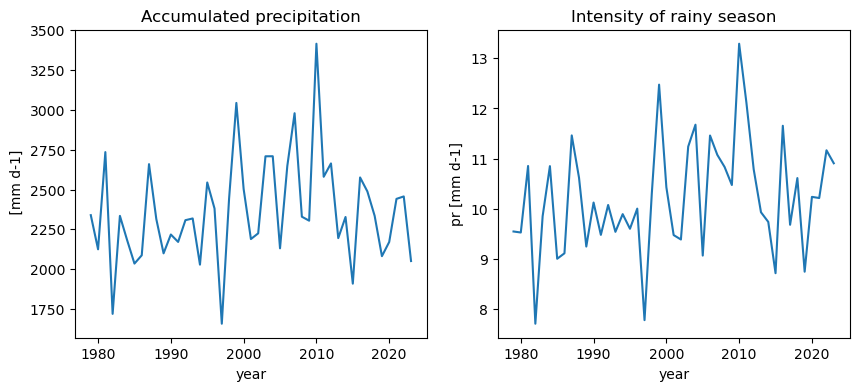

In [311]:
# could probably also just look at the wet-day frequency & intensity
fig, axs = plt.subplots(ncols = 2, figsize = (10,4), dpi = 100, sharey = False)

ax = axs[0]
accumulation.plot(ax = ax)
ax.set_title("Accumulated precipitation")

ax = axs[1]
intensities.plot(ax = ax)
ax.set_title("Intensity of rainy season")

In [319]:
# how Gaussian are these variables? Not terrible...
fig, axs = plt.subplots(ncols = 3, figsize = (16,4), dpi = 100, sharey = True)

ax = axs[0]
x = np.arange(50,200)
onsets.to_pandas().plot(ax = ax, kind = "density")
ax.plot(x, norm.pdf(x, loc = onsets.mean(), scale = onsets.std()))
ax.set_title("Onset of rainy season (RP: "+str(int(1/norm.sf(onsets.sel(year = 2023), loc = onsets.mean(), scale = onsets.std())))+")")
ax.axvline(onsets.sel(year = 2023), color = "magenta", ls = "--")

ax = axs[1]
x = np.arange(300,400)
ends.to_pandas().plot(ax = ax, kind = "density")
ax.plot(x, norm.pdf(x, loc = ends.mean(), scale = ends.std()))
ax.set_title("End of rainy season (RP: "+str(int(1/norm.cdf(ends.sel(year = 2023), loc = ends.mean(), scale = ends.std())))+")")
ax.axvline(ends.sel(year = 2023), color = "magenta", ls = "--")

ax = axs[2]
x = np.arange(150,300)
durations.to_pandas().plot(ax = ax, kind = "density")
ax.plot(x, norm.pdf(x, loc = durations.mean(), scale = durations.std()))
ax.set_title("Duration of rainy season (RP: "+str(int(1/norm.cdf(durations.sel(year = 2023), loc = durations.mean(), scale = durations.std())))+")")
ax.axvline(durations.sel(year = 2023), color = "magenta", ls = "--")

## **Relationship with ENSO**

_Will need to calculate unstandardised detrended nino3.4rel for final report_ 

             rs_onset    rs_end  rs_duration
rs_onset     1.000000  0.242313    -0.551936
rs_end       0.242313  1.000000     0.675294
rs_duration -0.551936  0.675294     1.000000


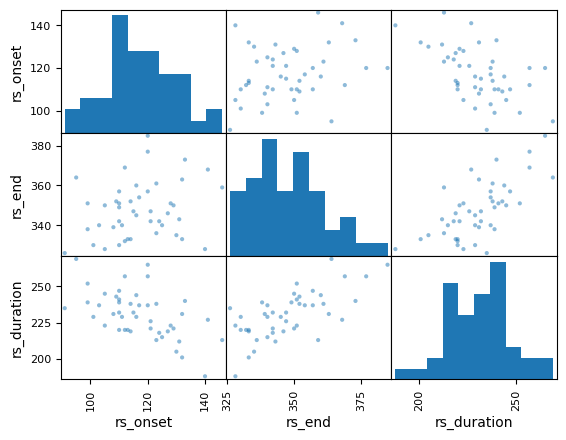

In [490]:
df = merge_byindex([da.to_dataframe() for da in [onsets, ends, durations]])
pd.plotting.scatter_matrix(df)

print(df.corr())

# ens of season has slightly more effect on duration than onset

In [491]:
nino34rel = decode_times(xr.open_dataset("data/iersst_nino3.4a_rel.nc", decode_times = False))["Nino3.4r"].sel(time = slice("1950", "2023")).dropna("time", "any")
nino34rel = xr.concat([nino34rel, nino34rel.isel(time = -1).expand_dims(time = [np.datetime64("2023-12-15")])], "time") # add dummy value for December 2023

In [492]:
def nino_rolling(agg, m): 
    nino = nino34rel.rolling(time = agg, center = False).mean().groupby("time.month")[m]
    nino = nino.assign_coords(time = nino.time.dt.year).rename(time = "year").sel(year = slice("1979", "2023"))
    return nino

In [623]:
print("Correlation with OND ENSO:")
print(merge_byindex([nino_rolling(3,12).to_dataframe()] + [da.to_dataframe() for da in [onsets, ends, durations]]).corr().iloc[0,1:])
print()
print("Correlation with 12-month ENSO:")
print(merge_byindex([nino_rolling(12,12).to_dataframe()] + [da.to_dataframe() for da in [onsets, ends, durations]]).corr().iloc[0,1:])
print()

Correlation with OND ENSO:
rs_onset      -0.128386
rs_end        -0.507828
rs_duration   -0.338879
Name: Nino3.4r, dtype: float64

Correlation with 12-month ENSO:
rs_onset      -0.193482
rs_end        -0.376828
rs_duration   -0.176798
Name: Nino3.4r, dtype: float64



In [558]:
nmonths = [3,6,12,18,24]
month_ending = list(range(13)[1:])

correlations = [xr.DataArray(data = np.array([[np.corrcoef(nino_rolling(agg, m), ts)[0,1] for agg in nmonths] for m in month_ending]),
                             name = "corr", dims = ["month_ending", "nmonths"]).expand_dims(corr_with = [ts.name]) for ts in [onsets, ends, durations, intensities]]

correlations = xr.concat(correlations, "corr_with").assign_coords(month_ending = month_ending, nmonths = nmonths).transpose()

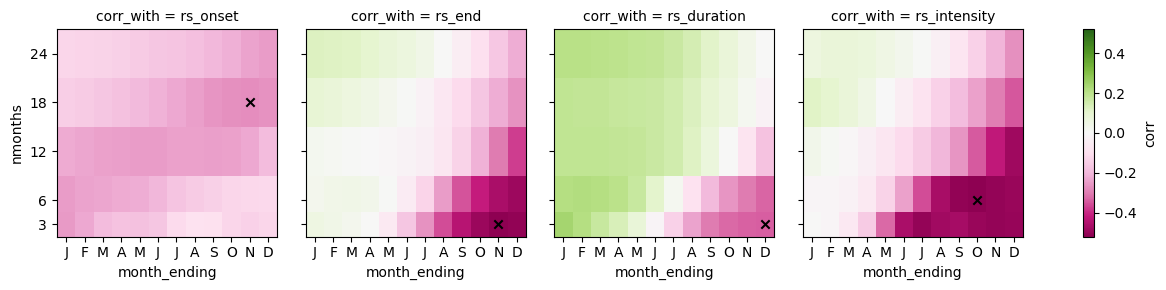

In [682]:
correlations.plot(col = "corr_with", cmap = "PiYG")

for ax in plt.gcf().axes[:-1]:
    ax.set_xticks([m + 1 for m in range(12)])
    ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"])
    ax.set_yticks(nmonths)
    
for i in range(4):
    ax = plt.gcf().axes[i]
    min_corr = correlations.isel(correlations.argmin(["month_ending", "nmonths"])).isel(corr_with = i)
    ax.scatter(min_corr.month_ending, min_corr.nmonths, marker = "x", color = "k")
    
plt.savefig("fig/nino-correlation-with-rainy-season.png")

Text(0.5, 1.03, 'Relationship between OND Nino3.4 and rainy season characteristics')

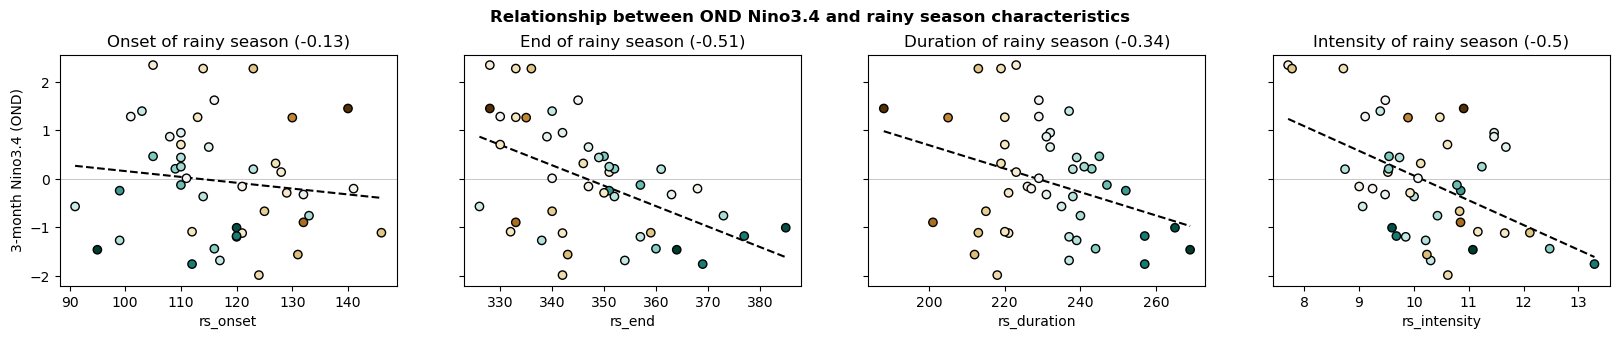

In [722]:
fig, axs = plt.subplots(ncols = 4, figsize = (20,3), dpi = 100, sharey = True)

ax = axs[0]
nm = 3; end = 12
rs_ts = onsets
nino_ts = nino_rolling(nm,end)
cbar = ax.scatter(rs_ts, nino_ts, c = durations, cmap = "BrBG", edgecolor = "k", zorder = 99)
xyline(rs_ts, nino_ts, ax = ax, ls = "--", color = "k")
ax.set_title("Onset of rainy season ("+str(round(np.corrcoef(rs_ts, nino_ts)[0,1], 2))+")")
ax.set_xlabel("rs_onset")
ax.set_ylabel("3-month Nino3.4 (OND)")

ax = axs[1]
rs_ts = ends
nino_ts = nino_rolling(nm,end)
cbar = ax.scatter(rs_ts, nino_ts, c = durations, cmap = "BrBG", edgecolor = "k", zorder = 99)
xyline(rs_ts, nino_ts, ax = ax, ls = "--", color = "k")
ax.set_title("End of rainy season ("+str(round(np.corrcoef(rs_ts, nino_ts)[0,1], 2))+")")
ax.set_xlabel("rs_end")

ax = axs[2]
rs_ts = durations
nino_ts = nino_rolling(nm,end)
cbar = ax.scatter(rs_ts, nino_ts, c = durations, cmap = "BrBG", edgecolor = "k", zorder = 99)
xyline(rs_ts, nino_ts, ax = ax, ls = "--", color = "k")
ax.set_title("Duration of rainy season ("+str(round(np.corrcoef(rs_ts, nino_ts)[0,1], 2))+")")
ax.set_xlabel("rs_duration")

ax = axs[3]
rs_ts = intensities
nino_ts = nino_rolling(nm,end)
cbar = ax.scatter(rs_ts, nino_ts, c = durations, cmap = "BrBG", edgecolor = "k", zorder = 99)
xyline(rs_ts, nino_ts, ax = ax, ls = "--", color = "k")
ax.set_title("Intensity of rainy season ("+str(round(np.corrcoef(rs_ts, nino_ts)[0,1], 2))+")")
ax.set_xlabel("rs_intensity")

for ax in axs:
    ax.axhline(0, color = "k", alpha = 0.3, lw = 0.5)
    
plt.suptitle("Relationship between OND Nino3.4 and rainy season characteristics", y = 1.03, fontweight = "bold")

Text(0.5, 1.03, 'Strongest observed relationship between Nino3.4 and rainy season characteristics')

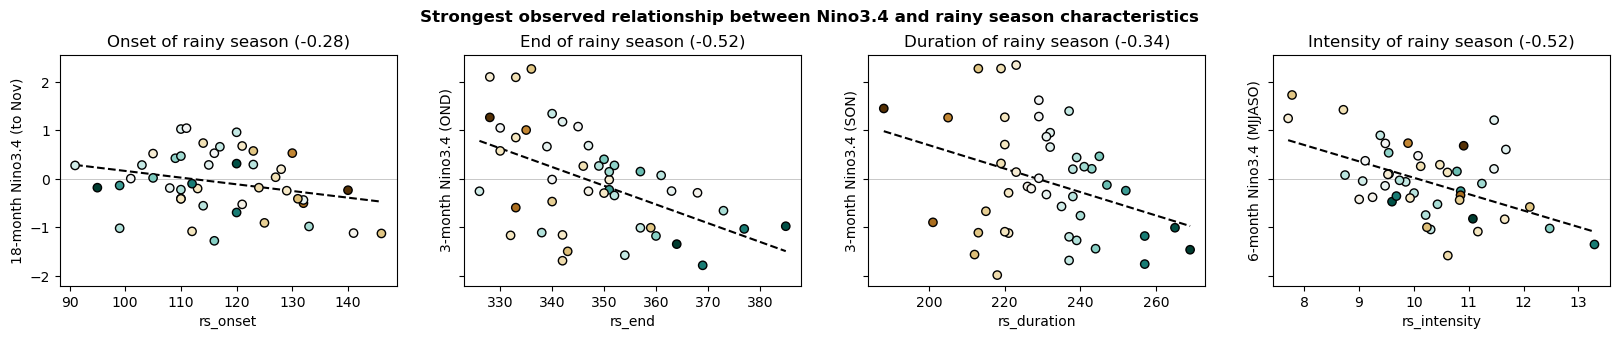

In [724]:
fig, axs = plt.subplots(ncols = 4, figsize = (20,3), dpi = 100, sharey = True)

ax = axs[0]
nm = 18; end = 11
rs_ts = onsets
nino_ts = nino_rolling(nm,end)
cbar = ax.scatter(rs_ts, nino_ts, c = durations, cmap = "BrBG", edgecolor = "k", zorder = 99)
xyline(rs_ts, nino_ts, ax = ax, ls = "--", color = "k")
ax.set_title("Onset of rainy season ("+str(round(np.corrcoef(rs_ts, nino_ts)[0,1], 2))+")")
ax.set_xlabel("rs_onset")
ax.set_ylabel("18-month Nino3.4 (to Nov)")

ax = axs[1]
nm = 3; end = 11
rs_ts = ends
nino_ts = nino_rolling(nm,end)
cbar = ax.scatter(rs_ts, nino_ts, c = durations, cmap = "BrBG", edgecolor = "k", zorder = 99)
xyline(rs_ts, nino_ts, ax = ax, ls = "--", color = "k")
ax.set_title("End of rainy season ("+str(round(np.corrcoef(rs_ts, nino_ts)[0,1], 2))+")")
ax.set_xlabel("rs_end")
ax.set_ylabel("3-month Nino3.4 (OND)")

ax = axs[2]
nm = 3; end = 12
rs_ts = durations
nino_ts = nino_rolling(nm,end)
cbar = ax.scatter(rs_ts, nino_ts, c = durations, cmap = "BrBG", edgecolor = "k", zorder = 99)
xyline(rs_ts, nino_ts, ax = ax, ls = "--", color = "k")
ax.set_title("Duration of rainy season ("+str(round(np.corrcoef(rs_ts, nino_ts)[0,1], 2))+")")
ax.set_xlabel("rs_duration")
ax.set_ylabel("3-month Nino3.4 (SON)")

ax = axs[3]
nm = 6; end = 10
rs_ts = intensities
nino_ts = nino_rolling(nm,end)
cbar = ax.scatter(rs_ts, nino_ts, c = durations, cmap = "BrBG", edgecolor = "k", zorder = 99)
xyline(rs_ts, nino_ts, ax = ax, ls = "--", color = "k")
ax.set_title("Intensity of rainy season ("+str(round(np.corrcoef(rs_ts, nino_ts)[0,1], 2))+")")
ax.set_xlabel("rs_intensity")
ax.set_ylabel("6-month Nino3.4 (MJJASO)")

for ax in axs:
    ax.axhline(0, color = "k", alpha = 0.3, lw = 0.5)
    
plt.suptitle("Strongest observed relationship between Nino3.4 and rainy season characteristics", y = 1.03, fontweight = "bold")

### **ENSO time series**

In [627]:
ts = nino_rolling(3,12)

csv_fnm = "panama-drought_nino-rel_OND"
csv_fullpath = "ts/"+csv_fnm+".dat"

if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

# create extra header lines for upload to Climate Explorer 
str1 = "# contact :: OND Nino3.4rel - Panama drought 2023-4, c.barnes22@imperial.ac.uk"
str2 = "# nino34rel [degC] OND mean of standardised Nino4.3 index over central Panama at "+csv_fnm
head = "# year nino34rel"

# make .dat file
! echo "$str1 " > $csv_fullpath
! echo "$str2" >> $csv_fullpath
! echo "$head" >> $csv_fullpath
ts.to_pandas().to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

In [719]:
ts = nino_rolling(6,12)

csv_fnm = "panama-drought_nino-rel_JASOND"
csv_fullpath = "ts/"+csv_fnm+".dat"

if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

# create extra header lines for upload to Climate Explorer 
str1 = "# contact :: JASOND Nino3.4rel - Panama drought 2023-4, c.barnes22@imperial.ac.uk"
str2 = "# nino34rel [degC] JASOND mean of standardised Nino4.3 index over central Panama at "+csv_fnm
head = "# year nino34rel"

# make .dat file
! echo "$str1 " > $csv_fullpath
! echo "$str2" >> $csv_fullpath
! echo "$head" >> $csv_fullpath
ts.to_pandas().to_csv(csv_fullpath, sep = " ", mode = "a", header = False)